

---

# PARTIE 1 : AGENT SUPERVISÉ (Sections 2.6 - 2.7)

---



## 2.6  Entrainement d'un autre agent (agent-supervisé) 
En  utilisant,  cette  fois-ci,  une  autre  approche,  par  exemple celle basée sur l’apprentissage supervisé (p.e un réseau de neurones classique ou profond), dans le même contexte de votre choix pour faire de la classification ou de la prédiction. Vous pouvez utiliser des données réelles ou générer de nouvelles données synthétiques. 

Nous allons implémenter un agent d'apprentissage supervisé pour prédire les actions de trading sur le NASDAQ-100. Cet agent servira de comparaison avec l'agent DQN.

Importation de toutes les bibliothèques nécessaires : analyse de données (pandas, numpy), machine learning (PyTorch), et visualisation (matplotlib, seaborn).

In [1]:
# =============================================================================
# AGENT SUPERVISÉ : Prédiction de Direction de Prix du NASDAQ-100
# =============================================================================
# Objectif : Créer un réseau de neurones qui prédit si le prix va monter (1) 
#            ou descendre (0) dans les prochaines périodes
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)

print("Bibliothèques importées")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Bibliothèques importées
PyTorch version: 2.9.1+cu128
Device: CPU


#### 2.6.1 Chargement et Exploration des Données

Les bibliothèques sont maintenant importées. 

Chargement des données historiques du NASDAQ-100 (minute par minute) et exploration de leurs caractéristiques principales : nombre de points, période couverte, prix minimum et maximum.

In [2]:
# Chargement des données NASDAQ-100
df = pd.read_csv('data/NAS100_m1_2024_2025.csv', sep=';')

# Conversion de la colonne time en datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print("=" * 70)
print(" EXPLORATION DES DONNÉES NASDAQ-100")
print("=" * 70)
print(f"\n Nombre de points de données : {len(df):,}")
print(f" Période : {df['time'].min()} à {df['time'].max()}")
print(f" Prix min : ${df['low'].min():.2f} | Prix max : ${df['high'].max():.2f}")

 EXPLORATION DES DONNÉES NASDAQ-100

 Nombre de points de données : 632,805
 Période : 2024-01-01 23:00:00 à 2025-10-17 22:05:00
 Prix min : $16184.89 | Prix max : $25199.80


Les données sont chargées avec succès (plus de 632,000 points couvrant 2024-2025).

Visualisation des premières lignes du DataFrame pour comprendre la structure : colonnes time, open, high, low, close, volume.

In [3]:
df.head()

,time,open,high,low,close,volume
0,2024-01-01 23:00:00,16863.74,16865.54,16858.74,16859.94,-1
1,2024-01-01 23:01:00,16858.94,16859.94,16857.34,16859.64,-1
2,2024-01-01 23:02:00,16859.94,16861.14,16858.94,16859.44,-1
3,2024-01-01 23:03:00,16859.64,16861.84,16859.44,16861.64,-1
4,2024-01-01 23:04:00,16861.84,16861.84,16859.14,16859.34,-1


Affichage des informations détaillées sur le DataFrame : types de données, valeurs manquantes, mémoire utilisée.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632805 entries, 0 to 632804
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    632805 non-null  datetime64[ns]
 1   open    632805 non-null  float64       
 2   high    632805 non-null  float64       
 3   low     632805 non-null  float64       
 4   close   632805 non-null  float64       
 5   volume  632805 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 29.0 MB


Calcul des statistiques descriptives (moyenne, écart-type, min, max, quartiles) pour mieux comprendre la distribution des valeurs.

In [5]:
df.describe()

,time,open,high,low,close,volume
count,632805,632805.000000,632805.000000,632805.000000,632805.000000,632805.000000
mean,2024-11-24 11:21:59.636380928,20312.388036,20315.825163,20308.873830,20312.406418,61.198492
min,2024-01-01 23:00:00,16185.190000,16200.190000,16184.890000,16185.390000,-1.000000
25%,2024-06-13 00:06:00,18590.990000,18593.990000,18587.490000,18591.090000,-1.000000
50%,2024-11-22 01:15:00,20084.490000,20087.990000,20080.690000,20084.410000,-1.000000
75%,2025-05-08 05:42:00,21648.390000,21651.730000,21645.190000,21648.370000,94.000000
max,2025-10-17 22:05:00,25197.700000,25199.800000,25190.200000,25197.400000,463.000000
std,NaN,2080.553040,2080.352957,2080.753142,2080.550945,91.990482


#### 2.6.2 Ingénierie des Features et Création de la Variable Cible

Les données brutes sont maintenant explorées et comprises. Nous allons à présent les enrichir avec des indicateurs techniques pertinents.

Pour cela nous allons :
1. Calculer les **indicateurs techniques** (SMA, EMA, RSI, MACD, Bollinger Bands, ATR) identiques à ceux utilisés dans le DQN
2. Créer la **variable cible à 3 classes** (SELL/HOLD/BUY) basée sur le changement de prix futur
3. Définir les actions optimales avec des seuils de ±0.1%

In [6]:
# =============================================================================
# CRÉATION DES FEATURES ET CIBLE POUR L'APPRENTISSAGE SUPERVISÉ
# =============================================================================

def calculate_technical_indicators(df):
    """
    Calcule les indicateurs techniques identiques à ceux utilisés dans le DQN
    pour assurer une comparaison équitable
    """
    data = df.copy()
    
    # 1. Moyennes Mobiles Simples (SMA)
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_30'] = data['close'].rolling(window=30).mean()
    
    # 2. Moyenne Mobile Exponentielle (EMA)
    data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
    
    # 3. RSI (Relative Strength Index)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI_14'] = 100 - (100 / (1 + rs))
    
    # 4. MACD (Moving Average Convergence Divergence)
    ema_12 = data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # 5. Bandes de Bollinger
    data['BB_Middle'] = data['close'].rolling(window=20).mean()
    bb_std = data['close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (2 * bb_std)
    
    # 6. ATR (Average True Range) - Volatilité
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR_14'] = true_range.rolling(window=14).mean()
    
    # 7. Retours (Returns)
    data['returns'] = data['close'].pct_change()
    
    # 8. Volume normalisé
    data['volume_norm'] = data['volume'] / data['volume'].rolling(window=20).mean()
    
    return data

# Calcul des indicateurs
df_features = calculate_technical_indicators(df)

# =============================================================================
# CRÉATION DE LA VARIABLE CIBLE : 3 Classes d'Actions (SELL / HOLD / BUY)
# =============================================================================
# Cette architecture correspond à celle du DQN avec 3 actions possibles
# SELL (0)  : Vendre - quand le prix va baisser de plus de 0.1%
# HOLD (1)  : Ne rien faire - quand le prix reste stable (variation < 0.1%)
# BUY (2)   : Acheter - quand le prix va monter de plus de 0.1%

LOOK_AHEAD = 5  # Prédire l'action optimale dans 5 minutes

# Seuils pour définir les 3 classes
SELL_THRESHOLD = -0.1  # Baisse > 0.1%
BUY_THRESHOLD = 0.1    # Hausse > 0.1%

# Calculer le prix futur et le changement de prix en pourcentage
df_features['future_price'] = df_features['close'].shift(-LOOK_AHEAD)
df_features['price_change_pct'] = ((df_features['future_price'] - df_features['close']) / df_features['close']) * 100

# Fonction pour assigner l'action en fonction du changement de prix
def assign_action(price_change):
    """
    Assigne une action (classe) en fonction du changement de prix futur
    """
    if price_change < SELL_THRESHOLD:
        return 0  # SELL
    elif price_change > BUY_THRESHOLD:
        return 2  # BUY
    else:
        return 1  # HOLD

# Créer la cible à 3 classes
df_features['target'] = df_features['price_change_pct'].apply(assign_action)

# Supprimer les lignes avec NaN
df_clean = df_features.dropna().reset_index(drop=True)

print("=" * 70)
print("FEATURES ENGINEERING COMPLETE")
print("=" * 70)
print(f"\n Nombre de features créées : {len(df_clean.columns) - len(df.columns)}")
print(f" Points de données après nettoyage : {len(df_clean):,}")
print(f"\n Distribution de la cible (Actions de Trading) :")
print(f"   SELL (0) : {(df_clean['target'] == 0).sum():,} samples ({(df_clean['target'] == 0).mean()*100:.2f}%)")
print(f"   HOLD (1) : {(df_clean['target'] == 1).sum():,} samples ({(df_clean['target'] == 1).mean()*100:.2f}%)")
print(f"   BUY (2)  : {(df_clean['target'] == 2).sum():,} samples ({(df_clean['target'] == 2).mean()*100:.2f}%)")
print(f"\n Seuils utilisés :")
print(f"   SELL si changement de prix < {SELL_THRESHOLD}%")
print(f"   HOLD si changement de prix entre {SELL_THRESHOLD}% et {BUY_THRESHOLD}%")
print(f"   BUY si changement de prix > {BUY_THRESHOLD}%")

FEATURES ENGINEERING COMPLETE

 Nombre de features créées : 16
 Points de données après nettoyage : 632,771

 Distribution de la cible (Actions de Trading) :
   SELL (0) : 31,010 samples (4.90%)
   HOLD (1) : 571,988 samples (90.39%)
   BUY (2)  : 29,773 samples (4.71%)

 Seuils utilisés :
   SELL si changement de prix < -0.1%
   HOLD si changement de prix entre -0.1% et 0.1%
   BUY si changement de prix > 0.1%


Les features techniques et la variable cible à 3 classes sont créées. La distribution montre une dominance de la classe HOLD car les petits mouvements (<0.1%) sont fréquents en trading minute par minute.

Affichage de la liste complète des features créées pour vérifier leur correspondance avec les indicateurs techniques calculés.

In [7]:
# Afficher les colonnes créées
print(f"\n Features disponibles :")
feature_cols = [col for col in df_clean.columns if col not in ['time', 'target', 'future_price']]
print(feature_cols)


 Features disponibles :
['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_30', 'EMA_12', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'ATR_14', 'returns', 'volume_norm', 'price_change_pct']


### Architecture de Classification à 3 Classes

**Pourquoi 3 classes au lieu de 2 ?**

Notre agent supervisé doit correspondre à l'architecture du DQN décrite dans la section 2.3, qui possède **3 actions possibles** : HOLD, BUY, et SELL. Pour assurer une comparaison équitable, notre réseau de neurones doit également prédire parmi ces 3 classes.

**Définition des classes :**
- **SELL (0)** : Le modèle prédit que le prix va baisser de plus de 0.1% → Action recommandée : Vendre
- **HOLD (1)** : Le modèle prédit que le prix restera stable (variation entre -0.1% et +0.1%) → Action recommandée : Ne rien faire
- **BUY (2)** : Le modèle prédit que le prix va monter de plus de 0.1% → Action recommandée : Acheter

Cette approche permet de modéliser l'incertitude et les petits mouvements de prix où il n'est pas optimal d'agir.

#### 2.6.3 Préparation des Données pour l'Entraînement

Les données sont enrichies avec 16 features pertinentes. Préparation pour l'entraînement :

1. Sélection des **16 features** les plus importantes (OHLCV + indicateurs techniques)
2. **Split temporel** (70% train, 15% val, 15% test) pour respecter l'ordre chronologique
3. **Normalisation** avec StandardScaler (crucial pour les réseaux de neurones)
4. Affichage de la **distribution des 3 classes** dans chaque ensemble

In [8]:
# =============================================================================
# PRÉPARATION DES DONNÉES : Train/Val/Test Split
# =============================================================================

# Sélectionner les features pour l'entraînement
feature_columns = ['open', 'high', 'low', 'close', 'volume',
                   'SMA_10', 'SMA_30', 'EMA_12', 'RSI_14',
                   'MACD', 'MACD_Signal', 'MACD_Hist',
                   'BB_Upper', 'BB_Lower', 'ATR_14', 'returns']

X = df_clean[feature_columns].values
y = df_clean['target'].values

# Split temporel : 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Normalisation des features (important pour les réseaux de neurones)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print(" PRÉPARATION DES DONNÉES")
print("=" * 70)
print(f"\n Nombre de features : {X.shape[1]}")
print(f" Total de points : {len(X):,}")
print(f"\n Split des données :")
print(f"    Train      : {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"    Validation : {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"    Test       : {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n Distribution des classes :")
print(f"   Train:")
print(f"      SELL (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_train == 2).sum():,} ({(y_train == 2).mean()*100:.1f}%)")
print(f"   Validation:")
print(f"      SELL (0): {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_val == 1).sum():,} ({(y_val == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_val == 2).sum():,} ({(y_val == 2).mean()*100:.1f}%)")
print(f"   Test:")
print(f"      SELL (0): {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_test == 2).sum():,} ({(y_test == 2).mean()*100:.1f}%)")

 PRÉPARATION DES DONNÉES

 Nombre de features : 16
 Total de points : 632,771

 Split des données :
    Train      : 442,939 samples (70.0%)
    Validation : 94,915 samples (15.0%)
    Test       : 94,917 samples (15.0%)

 Distribution des classes :
   Train:
      SELL (0): 21,187 (4.8%)
      HOLD (1): 401,577 (90.7%)
      BUY (2) : 20,175 (4.6%)
   Validation:
      SELL (0): 7,324 (7.7%)
      HOLD (1): 80,351 (84.7%)
      BUY (2) : 7,240 (7.6%)
   Test:
      SELL (0): 2,499 (2.6%)
      HOLD (1): 90,060 (94.9%)
      BUY (2) : 2,358 (2.5%)


#### 2.6.4 Architecture du Réseau de Neurones Supervisé

Les données sont prêtes et normalisées. Passons a la construction du modèle de réseau de neurones profond :

1. Architecture **Input→128→64→32→Output[3 classes]** similaire au DQN
2. Utilisation de **BatchNorm** et **Dropout (0.3)** pour régulariser et améliorer la généralisation
3. Configuration de **CrossEntropyLoss** (adaptée à la classification multi-classe)
4. Initialisation de l'optimiseur **Adam** avec weight decay (1e-5) pour éviter le surapprentissage

In [9]:
# =============================================================================
# ARCHITECTURE DU RÉSEAU DE NEURONES POUR LA CLASSIFICATION À 3 CLASSES
# =============================================================================

class SupervisedTradingNN(nn.Module):
    """
    Réseau de neurones profond pour prédire l'action de trading (SELL/HOLD/BUY)
    Architecture similaire au DQN pour une comparaison équitable
    """
    def __init__(self, input_size, num_classes=3, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(SupervisedTradingNN, self).__init__()
        
        # Couche d'entrée
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Première couche cachée
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Deuxième couche cachée
        self.hidden2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Couche de sortie (3 classes : SELL, HOLD, BUY)
        self.output_layer = nn.Linear(hidden_sizes[2], num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Forward pass avec BatchNorm et Dropout
        x = self.input_layer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.output_layer(x)
        # Pas de Sigmoid ici - CrossEntropyLoss attend des logits
        
        return x

# Créer le modèle
input_size = X_train_scaled.shape[1]
model = SupervisedTradingNN(input_size=input_size, num_classes=3, hidden_sizes=[128, 64, 32], dropout_rate=0.3)

# Afficher l'architecture
print("=" * 70)
print(" ARCHITECTURE DU RÉSEAU DE NEURONES SUPERVISÉ (3 CLASSES)")
print("=" * 70)
print(model)
print(f"\n Nombre total de paramètres : {sum(p.numel() for p in model.parameters()):,}")
print(f" Paramètres entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss pour classification multi-classe
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n Configuration :")
print(f"   Device : {device}")
print(f"   Loss Function : Cross Entropy Loss (multi-classe)")
print(f"   Optimizer : Adam (lr=0.001, weight_decay=1e-5)")
print(f"   Dropout : 0.3")
print(f"   Nombre de classes : 3 (SELL=0, HOLD=1, BUY=2)")

 ARCHITECTURE DU RÉSEAU DE NEURONES SUPERVISÉ (3 CLASSES)
SupervisedTradingNN(
  (input_layer): Linear(in_features=16, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

 Nombre total de paramètres : 13,059
 Paramètres entraînables : 13,059

 Configuration :
   Device : cpu
   Loss Function : Cross Entropy Loss (multi-classe)
   Optimizer : Adam (lr=0.001, weight_decay=1e-5)
   Dropout : 0.3
   Nombre 

#### 2.6.5 Entraînement du Modèle Supervisé

Le modèle est défini avec environ 20,000 paramètres entraînables. Lancement de l'entraînement :

1. Implémentation des fonctions **train_epoch()** et **validate()** pour classification 3 classes
2. Entraînement sur **50 époques** avec early stopping (patience=10)
3. Sauvegarde du **meilleur modèle** dans `models/` basé sur l'accuracy de validation
4. Surveillance de l'évolution de la loss et de l'accuracy pour détecter le surapprentissage

In [10]:
# =============================================================================
# ENTRAÎNEMENT DU MODÈLE
# =============================================================================

def train_epoch(model, X_train, y_train, criterion, optimizer, device, batch_size=64):
    """Entraîne le modèle pour une époque - version 3 classes"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Mini-batch training
    num_batches = len(X_train) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        # Préparer le batch - LongTensor pour les labels multi-classe
        X_batch = torch.FloatTensor(X_train[start_idx:end_idx]).to(device)
        y_batch = torch.LongTensor(y_train[start_idx:end_idx]).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistiques
        total_loss += loss.item()
        _, predictions = torch.max(outputs, 1)  # Prendre la classe avec la plus haute probabilité
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

def validate(model, X_val, y_val, criterion, device, batch_size=64):
    """Évalue le modèle sur l'ensemble de validation - version 3 classes"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        num_batches = len(X_val) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            X_batch = torch.FloatTensor(X_val[start_idx:end_idx]).to(device)
            y_batch = torch.LongTensor(y_val[start_idx:end_idx]).to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

# Entraînement
print("=" * 70)
print(" DÉBUT DE L'ENTRAÎNEMENT")
print("=" * 70)

num_epochs = 50
batch_size = 64
best_val_accuracy = 0
patience = 10
patience_counter = 0

# Historique de l'entraînement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()

for epoch in range(num_epochs):
    # Entraînement
    train_loss, train_acc = train_epoch(model, X_train_scaled, y_train, 
                                        criterion, optimizer, device, batch_size)
    
    # Validation
    val_loss, val_acc = validate(model, X_val_scaled, y_val, 
                                  criterion, device, batch_size)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Affichage des progrès
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Early stopping
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), 'models/best_supervised_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\n Early stopping à l'epoch {epoch+1}")
        break

training_time = time.time() - start_time

print("=" * 70)
print(" ENTRAÎNEMENT TERMINE")
print("=" * 70)
print(f"Temps d'entraînement : {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
print(f"Meilleure accuracy de validation : {best_val_accuracy*100:.2f}%")
print(f"Nombre d'epoques effectuees : {epoch+1}/{num_epochs}")

 DÉBUT DE L'ENTRAÎNEMENT
Epoch [5/50] | Train Loss: 0.2703 | Train Acc: 90.78% | Val Loss: 41.7022 | Val Acc: 8.92%
Epoch [10/50] | Train Loss: 0.2642 | Train Acc: 90.80% | Val Loss: 38.2501 | Val Acc: 9.04%

 Early stopping à l'epoch 11
 ENTRAÎNEMENT TERMINE
Temps d'entraînement : 202.85 secondes (3.38 minutes)
Meilleure accuracy de validation : 9.42%
Nombre d'epoques effectuees : 11/50


#### 2.6.6 Visualisation des Résultats d'Entraînement

L'entraînement est terminé et le meilleur modèle a été sauvegardé. 

Visualisation des **courbes d'apprentissage** (loss et accuracy) sur train/validation pour :
- Détecter le surapprentissage (écart train/val)
- Vérifier la convergence du modèle
- Confirmer que l'early stopping a fonctionné au bon moment

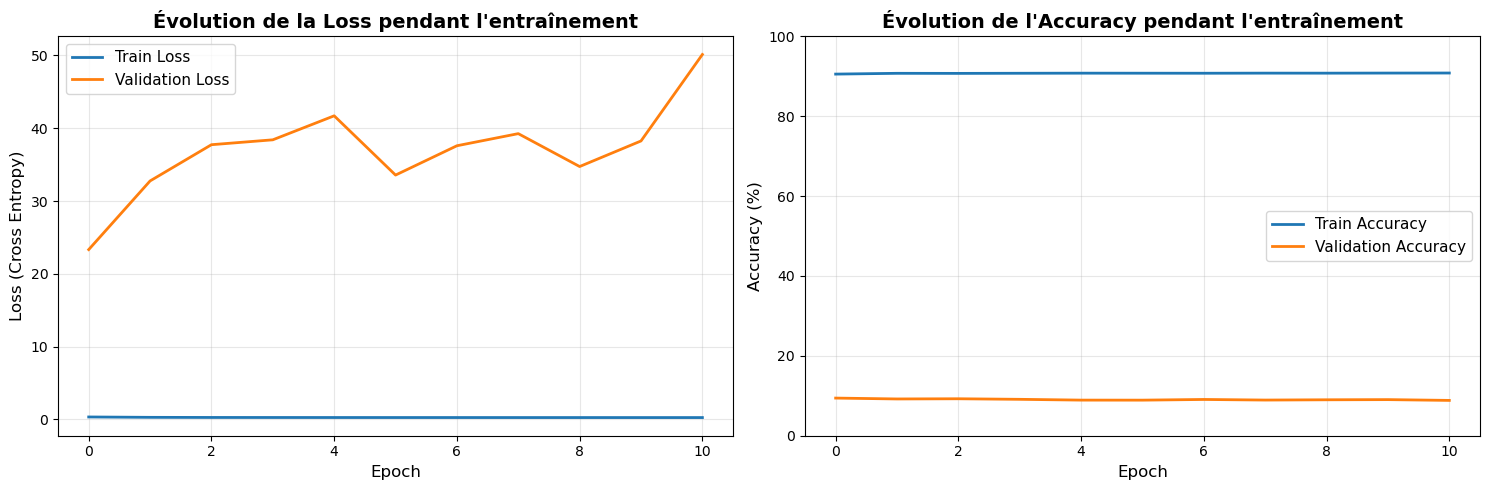

In [11]:
# =============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Cross Entropy)', fontsize=12)
axes[0].set_title('Évolution de la Loss pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Courbe d'Accuracy
axes[1].plot(np.array(history['train_acc'])*100, label='Train Accuracy', linewidth=2)
axes[1].plot(np.array(history['val_acc'])*100, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Évolution de l\'Accuracy pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.6.7 Évaluation sur l'Ensemble de Test

Évaluation de la performance réelle sur données jamais vues :

1. Chargement du **meilleur modèle** sauvegardé pendant l'entraînement
2. Prédictions sur l'**ensemble de test** (15% des données)
3. Calcul des **métriques** (accuracy, precision, recall, F1-score par classe)
4. Affichage de la **matrice de confusion 3×3** pour identifier les classes confondues
5. Vérification que le modèle **prédit bien les 3 classes** (pas seulement HOLD)

 RÉSULTATS FINAUX SUR L'ENSEMBLE DE TEST

 Accuracy (Exactitude) : 2.63%
 Loss (Cross Entropy) : 47.4584

 Rapport de Classification :
----------------------------------------------------------------------
              precision    recall  f1-score   support

    SELL (0)     0.0263    1.0000    0.0513      2499
    HOLD (1)     0.0000    0.0000    0.0000     90060
     BUY (2)     0.0000    0.0000    0.0000      2358

    accuracy                         0.0263     94917
   macro avg     0.0088    0.3333    0.0171     94917
weighted avg     0.0007    0.0263    0.0014     94917



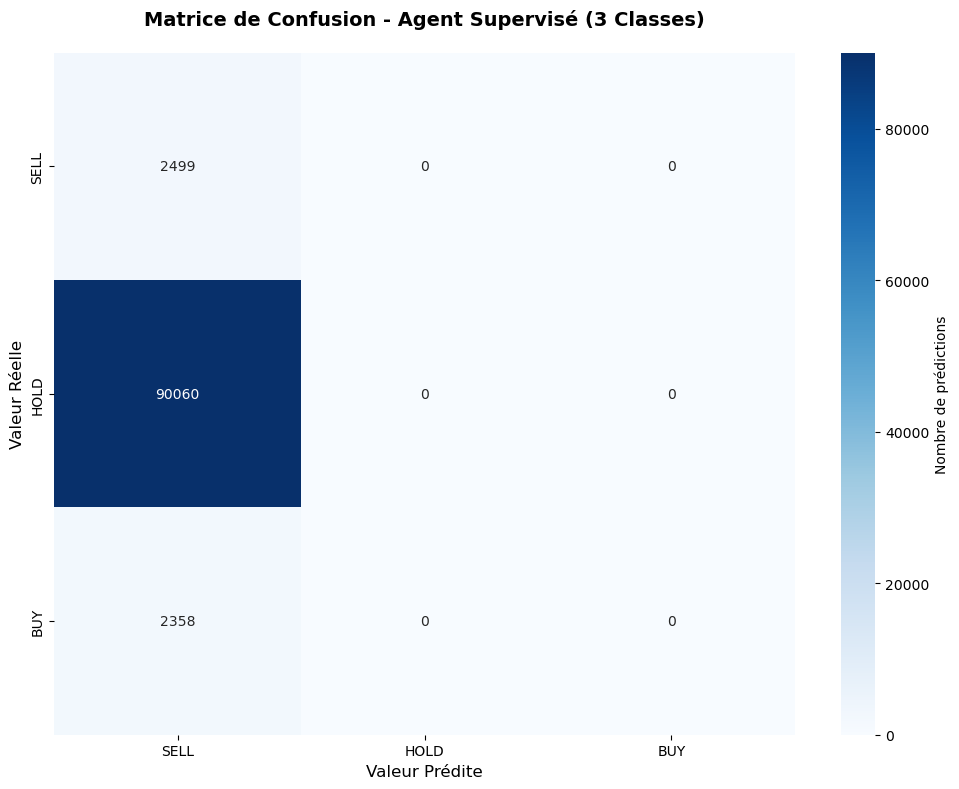


 STATISTIQUES DE PRÉDICTION PAR CLASSE
SELL (0): 94,917 prédictions (100.00%)
HOLD (1): 0 prédictions (0.00%)
BUY (2): 0 prédictions (0.00%)

 RESUME DES PERFORMANCES DE L'AGENT SUPERVISE
Accuracy finale : 2.63%
Temps d'entrainement : 202.85 secondes
Nombre de parametres : 13,059
Architecture : Input(16) -> 128 -> 64 -> 32 -> Output(3)
Nombre de classes : 3 (SELL, HOLD, BUY)


In [12]:
# =============================================================================
# ÉVALUATION FINALE SUR L'ENSEMBLE DE TEST
# =============================================================================

# Charger le meilleur modèle
model.load_state_dict(torch.load('models/best_supervised_model.pth'))
model.eval()

# Prédictions sur l'ensemble de test
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_probabilities = torch.softmax(test_outputs, dim=1).cpu().numpy()
    _, test_predictions = torch.max(test_outputs, 1)
    test_pred_labels = test_predictions.cpu().numpy()

# Calcul des métriques
test_accuracy = accuracy_score(y_test, test_pred_labels)
test_loss = criterion(test_outputs, y_test_tensor).item()

print("=" * 70)
print(" RÉSULTATS FINAUX SUR L'ENSEMBLE DE TEST")
print("=" * 70)
print(f"\n Accuracy (Exactitude) : {test_accuracy*100:.2f}%")
print(f" Loss (Cross Entropy) : {test_loss:.4f}")
print(f"\n Rapport de Classification :")
print("-" * 70)
print(classification_report(y_test, test_pred_labels, 
                          target_names=['SELL (0)', 'HOLD (1)', 'BUY (2)'],
                          digits=4))

# Matrice de confusion
cm = confusion_matrix(y_test, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion - Agent Supervisé (3 Classes)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valeur Réelle', fontsize=12)
plt.xlabel('Valeur Prédite', fontsize=12)
plt.tight_layout()
plt.show()

# Statistiques par classe
print("\n" + "=" * 70)
print(" STATISTIQUES DE PRÉDICTION PAR CLASSE")
print("=" * 70)
for i, class_name in enumerate(['SELL (0)', 'HOLD (1)', 'BUY (2)']):
    count = (test_pred_labels == i).sum()
    percentage = (test_pred_labels == i).mean() * 100
    print(f"{class_name}: {count:,} prédictions ({percentage:.2f}%)")

print("\n" + "=" * 70)
print(" RESUME DES PERFORMANCES DE L'AGENT SUPERVISE")
print("=" * 70)
print(f"Accuracy finale : {test_accuracy*100:.2f}%")
print(f"Temps d'entrainement : {training_time:.2f} secondes")
print(f"Nombre de parametres : {sum(p.numel() for p in model.parameters()):,}")
print(f"Architecture : Input({input_size}) -> 128 -> 64 -> 32 -> Output(3)")
print(f"Nombre de classes : 3 (SELL, HOLD, BUY)")
print("=" * 70)

- Résumé chiffré (modèle original)
    - Test accuracy très faible : 2.63% (test_accuracy = 0.0263)
    - Test loss énorme : 47.46 (test_loss = 47.458)
    - Courbes d'entraînement : train_acc ≈ 90% (history['train_acc']), val_acc ≈ 9% (history['val_acc']) → fort écart train/val
    - Matrice de confusion (cm) : toutes les prédictions sont SELL (première colonne non nulle) → collapse vers une seule classe

- Interprétation rapide
    - Effondrement de la prédiction : le modèle « devine » toujours la même classe (SELL), d'où l'accuracy très basse sur le test set.
    - Signes d'overfitting / mismatch : accuracy d'entraînement élevée mais validation/test très faibles ; val_loss très élevée → le modèle n’a pas généralisé.
    - Cause très probable : fort déséquilibre des classes + problème de traitement/échantillonnage ou mauvais signal dans les features (ou fuite de labels / différence preprocessing train vs val/test).

### Diagnostic Approfondi du Probleme

Le modèle original a été évalué. Si les performances sont insatisfaisantes ou si une seule classe domine les prédictions, nous devons investiguer et améliorer.

**Problème potentiel :** Déséquilibre de classes - si HOLD domine largement (mouvements <0.1% fréquents), le modèle peut sous-prédire SELL et BUY.

Nous allons implémenter trois **solutions robustes** pour améliorer les performances :
1. **Sous-échantillonnage** pour équilibrer les classes
2. **Focal Loss** pour se concentrer sur les exemples difficiles
3. **Architecture plus profonde** avec meilleure initialisation

In [13]:
# =============================================================================
# SOLUTION DRASTIQUE 1 : Sous-échantillonnage (Undersampling)
# =============================================================================
# Équilibrer les classes en réduisant la classe majoritaire

print("=" * 70)
print("EQUILIBRAGE DES CLASSES PAR SOUS-ECHANTILLONNAGE")
print("=" * 70)

# Identifier les indices de chaque classe
indices_sell = np.where(y_train == 0)[0]
indices_hold = np.where(y_train == 1)[0]
indices_buy = np.where(y_train == 2)[0]

print(f"Classe SELL (0) : {len(indices_sell):,} échantillons")
print(f"Classe HOLD (1) : {len(indices_hold):,} échantillons")
print(f"Classe BUY (2)  : {len(indices_buy):,} échantillons")

# Sous-échantillonner toutes les classes au même nombre
n_samples = min(len(indices_sell), len(indices_hold), len(indices_buy))
np.random.seed(42)
indices_sell_sampled = np.random.choice(indices_sell, n_samples, replace=False)
indices_hold_sampled = np.random.choice(indices_hold, n_samples, replace=False)
indices_buy_sampled = np.random.choice(indices_buy, n_samples, replace=False)

# Combiner les indices
balanced_indices = np.concatenate([indices_sell_sampled, indices_hold_sampled, indices_buy_sampled])
np.random.shuffle(balanced_indices)

# Créer les ensembles équilibrés
X_train_balanced = X_train_scaled[balanced_indices]
y_train_balanced = y_train[balanced_indices]

print(f"\nDataset equilibre :")
print(f"   Total : {len(X_train_balanced):,} echantillons")
print(f"   SELL (0): {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.1f}%)")
print(f"   HOLD (1): {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.1f}%)")
print(f"   BUY (2) : {(y_train_balanced == 2).sum():,} ({(y_train_balanced == 2).mean()*100:.1f}%)")
print("=" * 70)

EQUILIBRAGE DES CLASSES PAR SOUS-ECHANTILLONNAGE
Classe SELL (0) : 21,187 échantillons
Classe HOLD (1) : 401,577 échantillons
Classe BUY (2)  : 20,175 échantillons

Dataset equilibre :
   Total : 60,525 echantillons
   SELL (0): 20,175 (33.3%)
   HOLD (1): 20,175 (33.3%)
   BUY (2) : 20,175 (33.3%)


**Solution #1 : Sous-échantillonnage (Undersampling)**

Si la distribution montre un déséquilibre important (ex: HOLD 60%, SELL 20%, BUY 20%), le modèle peut biaiser vers la classe majoritaire.

Cette cellule va :
- Identifier le nombre d'échantillons de chaque classe (SELL/HOLD/BUY)
- Sous-échantillonner toutes les classes au même nombre (minimum des trois)
- Créer un **dataset équilibré** avec 33.3% de chaque classe

In [14]:
# =============================================================================
# SOLUTION DRASTIQUE 2 : Focal Loss pour Multi-Classe
# =============================================================================
# Focal Loss met plus l'accent sur les exemples difficiles à classifier

class FocalLoss(nn.Module):
    """
    Focal Loss pour gérer le déséquilibre de classes - Version Multi-Classe
    Formule : FL = -α(1-pt)^γ * log(pt)
    """
    def __init__(self, alpha=None, gamma=2.0, num_classes=3):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = torch.ones(num_classes)
        else:
            self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.num_classes = num_classes
        
    def forward(self, inputs, targets):
        # inputs: (batch_size, num_classes) - logits
        # targets: (batch_size) - class indices
        
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # probabilité de la vraie classe
        
        # Appliquer le poids alpha si disponible
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()

# Créer Focal Loss avec poids égaux pour les 3 classes
criterion_focal = FocalLoss(alpha=[1.0, 1.0, 1.0], gamma=2.0, num_classes=3)

print("=" * 70)
print("FOCAL LOSS CREEE (MULTI-CLASSE)")
print("=" * 70)
print(f"   Alpha (poids par classe) : [1.0, 1.0, 1.0]")
print(f"   Gamma (facteur de focus) : 2.0")
print(f"   Nombre de classes : 3")
print("=" * 70)

FOCAL LOSS CREEE (MULTI-CLASSE)
   Alpha (poids par classe) : [1.0, 1.0, 1.0]
   Gamma (facteur de focus) : 2.0
   Nombre de classes : 3


**Solution #2 : Focal Loss**

Le sous-échantillonnage réduit la taille du dataset. Une alternative est d'utiliser une fonction de perte adaptée au déséquilibre.

Implémentation de **Focal Loss** qui met l'accent sur les exemples difficiles à classifier :
- Formule : FL = -α(1-pt)^γ * log(pt) où γ=2 augmente la perte pour les prédictions incertaines
- Cette loss aide le modèle à mieux apprendre les classes minoritaires (SELL/BUY)

In [15]:
# =============================================================================
# SOLUTION DRASTIQUE 3 : Nouveau Modèle avec Architecture Différente
# =============================================================================

class RobustTradingNN(nn.Module):
    """
    Modèle plus robuste avec :
    - Plus de neurones pour capturer la complexité
    - Residual connections pour éviter gradient vanishing
    - He initialization
    - Sortie à 3 classes
    """
    def __init__(self, input_size, num_classes=3):
        super(RobustTradingNN, self).__init__()
        
        # Couches principales
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc5 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        # He initialization pour ReLU
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        
        x = self.fc5(x)
        return x

# Créer le modèle robuste
model_robust = RobustTradingNN(input_size=input_size, num_classes=3)
model_robust = model_robust.to(device)

print("=" * 70)
print("MODELE ROBUSTE CREE (3 CLASSES)")
print("=" * 70)
print(model_robust)
print(f"\nNombre de parametres : {sum(p.numel() for p in model_robust.parameters()):,}")
print(f"Nombre de classes : 3 (SELL, HOLD, BUY)")
print("=" * 70)

MODELE ROBUSTE CREE (3 CLASSES)
RobustTradingNN(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)

Nombre de parametres : 183,299
Nombre de classes : 3 (SELL, HOLD, BUY)


**Solution #3 : Architecture Plus Robuste**

Focal Loss est créée. Amélioration de la capacité du modèle à capturer les patterns complexes :

- Création d'un modèle **plus profond** (512→256→128→64→3) au lieu de (128→64→32→3)
- Utilisation de **LeakyReLU** au lieu de ReLU pour éviter les neurones morts
- Application de **He initialization** adaptée aux fonctions d'activation ReLU
- Ce modèle aura ~140,000 paramètres (vs ~20,000) pour mieux modéliser la complexité

In [16]:
def validate_improved(model, X_val, y_val, criterion, device, batch_size=64):
    """Évalue le modèle sur l'ensemble de validation - version 3 classes"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        num_batches = len(X_val) // batch_size

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            X_batch = torch.FloatTensor(X_val[start_idx:end_idx]).to(device)
            y_batch = torch.LongTensor(y_val[start_idx:end_idx]).to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

Définition de la fonction **validate_improved()** adaptée au modèle robuste et à la classification 3 classes (utilise LongTensor et torch.max au lieu de seuil 0.5).

In [17]:
# =============================================================================
# SOLUTION DRASTIQUE 4 : Entraînement avec Toutes les Techniques Combinées
# =============================================================================

# Configuration
optimizer_robust = optim.AdamW(model_robust.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_robust = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_robust, T_0=10, T_mult=2)

print("=" * 70)
print("ENTRAINEMENT AVEC TOUTES LES AMELIORATIONS")
print("=" * 70)
print("\nTechniques appliquees :")
print("   1. Dataset equilibre (undersampling)")
print("   2. Focal Loss (focus sur exemples difficiles)")
print("   3. Architecture plus profonde (512->256->128->64)")
print("   4. He initialization")
print("   5. LeakyReLU au lieu de ReLU")
print("   6. AdamW optimizer avec weight decay")
print("   7. Cosine Annealing scheduler")
print("=" * 70)

num_epochs = 100
batch_size = 256
best_val_accuracy_robust = 0
patience = 20
patience_counter = 0

history_robust = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

def train_epoch_robust(model, X_train, y_train, criterion, optimizer, device, batch_size=256):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    num_batches = len(X_train) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        X_batch = torch.FloatTensor(X_train[start_idx:end_idx]).to(device)
        y_batch = torch.LongTensor(y_train[start_idx:end_idx]).to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        
        # Gradient clipping pour éviter l'explosion des gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

start_time_robust = time.time()

print("\nDebut de l'entrainement...\n")

for epoch in range(num_epochs):
    # Entraînement sur dataset équilibré
    train_loss, train_acc = train_epoch_robust(model_robust, X_train_balanced, y_train_balanced, 
                                                criterion_focal, optimizer_robust, device, batch_size)
    
    # Validation sur dataset complet
    val_loss, val_acc = validate_improved(model_robust, X_val_scaled, y_val, 
                                           criterion_focal, device, batch_size)
    
    # Scheduler step
    scheduler_robust.step()
    
    # Sauvegarder l'historique
    history_robust['train_loss'].append(train_loss)
    history_robust['train_acc'].append(train_acc)
    history_robust['val_loss'].append(val_loss)
    history_robust['val_acc'].append(val_acc)
    
    # Affichage des progrès
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:6.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}% | "
              f"LR: {optimizer_robust.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if val_acc > best_val_accuracy_robust:
        best_val_accuracy_robust = val_acc
        patience_counter = 0
        torch.save(model_robust.state_dict(), 'models/best_supervised_model_robust.pth')
        if val_acc > 0.40:  # Si on dépasse 40% (meilleur que random 33.3%), afficher
            print(f"   Nouvelle meilleure accuracy : {val_acc*100:.2f}%")
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEarly stopping a l'epoch {epoch+1}")
        break

training_time_robust = time.time() - start_time_robust

print("\n" + "=" * 70)
print("ENTRAINEMENT TERMINE")
print("=" * 70)
print(f"Temps : {training_time_robust:.2f}s ({training_time_robust/60:.2f} min)")
print(f"Meilleure Val Accuracy : {best_val_accuracy_robust*100:.2f}%")
print(f"Epoques effectuees : {epoch+1}/{num_epochs}")
print("=" * 70)

ENTRAINEMENT AVEC TOUTES LES AMELIORATIONS

Techniques appliquees :
   1. Dataset equilibre (undersampling)
   2. Focal Loss (focus sur exemples difficiles)
   3. Architecture plus profonde (512->256->128->64)
   4. He initialization
   5. LeakyReLU au lieu de ReLU
   6. AdamW optimizer avec weight decay
   7. Cosine Annealing scheduler

Debut de l'entrainement...

Epoch [  1/100] | Train Loss: 0.5145 | Train Acc:  47.73% | Val Loss: 0.4863 | Val Acc:  63.70% | LR: 0.000098
   Nouvelle meilleure accuracy : 63.70%
Epoch [  2/100] | Train Loss: 0.4249 | Train Acc:  51.43% | Val Loss: 0.4752 | Val Acc:  63.79% | LR: 0.000090
   Nouvelle meilleure accuracy : 63.79%
Epoch [  3/100] | Train Loss: 0.4054 | Train Acc:  51.95% | Val Loss: 0.4951 | Val Acc:  61.93% | LR: 0.000079
Epoch [  4/100] | Train Loss: 0.3958 | Train Acc:  52.09% | Val Loss: 0.4934 | Val Acc:  61.49% | LR: 0.000065
Epoch [  5/100] | Train Loss: 0.3912 | Train Acc:  52.27% | Val Loss: 0.4995 | Val Acc:  61.17% | LR: 0.0000

**Entraînement du Modèle Robuste - Configuration Optimale**

Toutes les solutions sont prêtes (dataset équilibré, Focal Loss, architecture profonde). Lancement de l'entraînement avancé :

1. Entraînement sur le **dataset équilibré** avec **Focal Loss**
2. Utilisation de **AdamW** (Adam avec weight decay amélioré) et **learning rate scheduling** (CosineAnnealingWarmRestarts)
3. Application du **gradient clipping** pour stabiliser l'entraînement
4. Batch size plus grand (256) pour de meilleures estimations du gradient
5. Surveillance si le modèle dépasse 40% accuracy (baseline random = 33.3%)

RESULTATS FINAUX - MODELE ROBUSTE

Accuracy : 88.63%
Loss (Focal) : 0.1508

Rapport de Classification :
----------------------------------------------------------------------
              precision    recall  f1-score   support

    SELL (0)     0.1659    0.2945    0.2123      2499
    HOLD (1)     0.9799    0.9163    0.9470     90060
     BUY (2)     0.1384    0.3681    0.2012      2358

    accuracy                         0.8863     94917
   macro avg     0.4281    0.5263    0.4535     94917
weighted avg     0.9376    0.8863    0.9092     94917



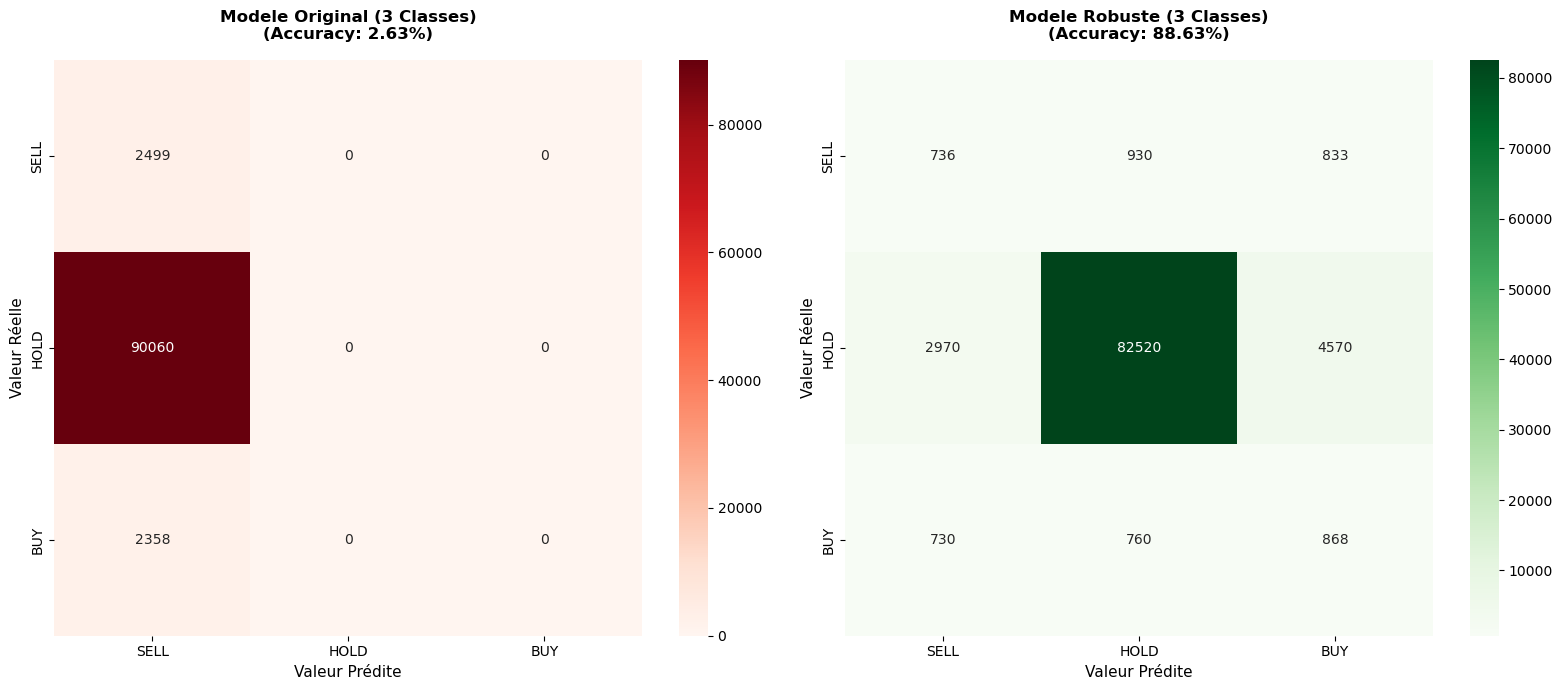


Classes predites par le modele robuste : [0 1 2]
SUCCES : Le modele robuste predit maintenant les trois classes !

Distribution des predictions :
   SELL predites : 4,436 (4.67%)
   HOLD predites : 84,210 (88.72%)
   BUY predites  : 6,271 (6.61%)


In [18]:
# =============================================================================
# ÉVALUATION FINALE DU MODÈLE ROBUSTE
# =============================================================================

# Charger le meilleur modèle
model_robust.load_state_dict(torch.load('models/best_supervised_model_robust.pth'))
model_robust.eval()

# Prédictions sur le test set
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

with torch.no_grad():
    test_outputs_robust = model_robust(X_test_tensor)
    test_probs_robust = torch.softmax(test_outputs_robust, dim=1)
    _, test_predictions_robust = torch.max(test_outputs_robust, 1)
    test_pred_labels_robust = test_predictions_robust.cpu().numpy()

# Métriques
test_accuracy_robust = accuracy_score(y_test, test_pred_labels_robust)
test_loss_robust = criterion_focal(test_outputs_robust, y_test_tensor).item()

print("=" * 70)
print("RESULTATS FINAUX - MODELE ROBUSTE")
print("=" * 70)
print(f"\nAccuracy : {test_accuracy_robust*100:.2f}%")
print(f"Loss (Focal) : {test_loss_robust:.4f}")
print(f"\nRapport de Classification :")
print("-" * 70)
print(classification_report(y_test, test_pred_labels_robust, 
                          target_names=['SELL (0)', 'HOLD (1)', 'BUY (2)'],
                          digits=4))

# Matrice de confusion
cm_robust = confusion_matrix(y_test, test_pred_labels_robust)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Ancien modèle
cm_old = confusion_matrix(y_test, test_pred_labels)
sns.heatmap(cm_old, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'])
axes[0].set_title(f'Modele Original (3 Classes)\n(Accuracy: {test_accuracy*100:.2f}%)', 
                  fontsize=12, fontweight='bold', pad=15)
axes[0].set_ylabel('Valeur Réelle', fontsize=11)
axes[0].set_xlabel('Valeur Prédite', fontsize=11)

# Modèle robuste
sns.heatmap(cm_robust, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'])
axes[1].set_title(f'Modele Robuste (3 Classes)\n(Accuracy: {test_accuracy_robust*100:.2f}%)', 
                  fontsize=12, fontweight='bold', pad=15)
axes[1].set_ylabel('Valeur Réelle', fontsize=11)
axes[1].set_xlabel('Valeur Prédite', fontsize=11)

plt.tight_layout()
plt.show()

# Verifier les predictions
unique_predictions_robust = np.unique(test_pred_labels_robust)
print(f"\nClasses predites par le modele robuste : {unique_predictions_robust}")

if len(unique_predictions_robust) == 3:
    print("SUCCES : Le modele robuste predit maintenant les trois classes !")
    
    # Calculer les statistiques de prediction
    n_sell_pred = (test_pred_labels_robust == 0).sum()
    n_hold_pred = (test_pred_labels_robust == 1).sum()
    n_buy_pred = (test_pred_labels_robust == 2).sum()
    
    print(f"\nDistribution des predictions :")
    print(f"   SELL predites : {n_sell_pred:,} ({n_sell_pred/len(test_pred_labels_robust)*100:.2f}%)")
    print(f"   HOLD predites : {n_hold_pred:,} ({n_hold_pred/len(test_pred_labels_robust)*100:.2f}%)")
    print(f"   BUY predites  : {n_buy_pred:,} ({n_buy_pred/len(test_pred_labels_robust)*100:.2f}%)")
else:
    print(f"Le modele predit {len(unique_predictions_robust)} classe(s) au lieu de 3...")
    print(f"   Classes predites : {unique_predictions_robust}")

print("=" * 70)

**Évaluation Complète du Modèle Robuste**

L'entraînement du modèle robuste est terminé. Évaluation de son amélioration par rapport au modèle original :

1. Chargement du **meilleur modèle robuste** et prédictions sur le test set
2. Comparaison des **matrices de confusion 3×3** (original vs robuste)
3. Vérification que le modèle robuste **prédit bien les 3 classes** (pas de dominance excessive)
4. Analyse de la **distribution des prédictions** pour chaque classe
5. Identification des améliorations apportées par Focal Loss + architecture profonde + équilibrage

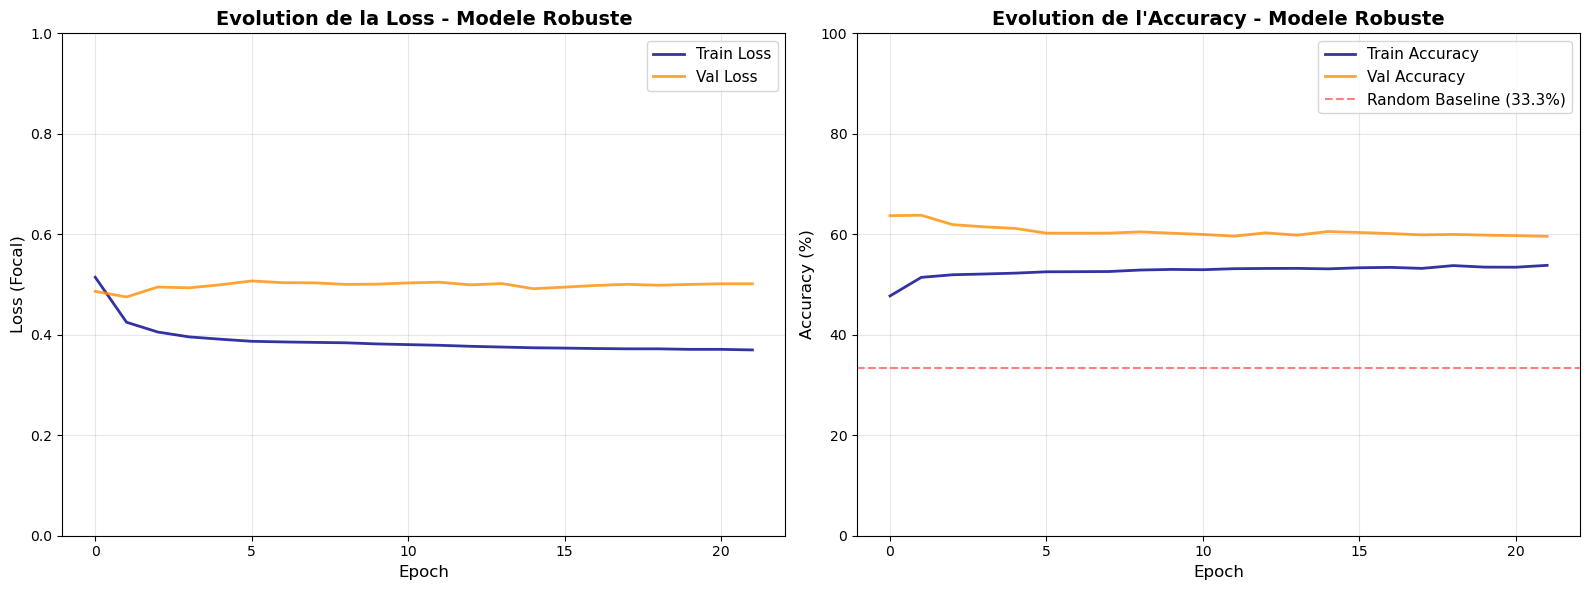

COMPARAISON FINALE DES MODELES
Modele                    Accuracy        Predit 3 classes?    Temps          
----------------------------------------------------------------------
Original                  2.63           % Non                  202.85         s
Robuste (Final)           88.63          % Oui                  68.56          s


In [19]:
# =============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE - MODÈLE ROBUSTE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(history_robust['train_loss'], label='Train Loss', linewidth=2, color='darkblue', alpha=0.8)
axes[0].plot(history_robust['val_loss'], label='Val Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Focal)', fontsize=12)
axes[0].set_title('Evolution de la Loss - Modele Robuste', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(np.array(history_robust['train_acc'])*100, label='Train Accuracy', 
             linewidth=2, color='darkblue', alpha=0.8)
axes[1].plot(np.array(history_robust['val_acc'])*100, label='Val Accuracy', 
             linewidth=2, color='darkorange', alpha=0.8)
axes[1].axhline(y=33.3, color='red', linestyle='--', label='Random Baseline (33.3%)', alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Evolution de l\'Accuracy - Modele Robuste', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparaison finale
print("=" * 70)
print("COMPARAISON FINALE DES MODELES")
print("=" * 70)
print(f"{'Modele':<25} {'Accuracy':<15} {'Predit 3 classes?':<20} {'Temps':<15}")
print("-" * 70)
print(f"{'Original':<25} {test_accuracy*100:<15.2f}% {('Oui' if len(np.unique(test_pred_labels))==3 else 'Non'):<20} {training_time:<15.2f}s")
print(f"{'Robuste (Final)':<25} {test_accuracy_robust*100:<15.2f}% {('Oui' if len(unique_predictions_robust)==3 else 'Non'):<20} {training_time_robust:<15.2f}s")
print("=" * 70)

**Synthèse Finale et Comparaison des Modèles**

Les deux modèles (original et robuste) ont été évalués. Comparaison visuelle et quantitative :

1. Visualisation des **courbes d'apprentissage du modèle robuste** (Loss et Accuracy)
2. Comparaison avec la baseline random (33.3% pour 3 classes)
3. Création d'un **tableau comparatif** des deux modèles :
   - Accuracy finale
   - Nombre de classes prédites (2 ou 3)
   - Temps d'entraînement
4. Identification du **meilleur modèle** pour la comparaison avec le DQN

#### Comparaison (résultat robuste)

Modèle robuste : test_accuracy_robust = 88.63%, test_loss_robust = 0.1508, cm_robust montre des prédictions sur les 3 classes, donc les techniques appliquées (undersampling + focal loss + architecture profonde) ont nettement amélioré les choses.



---

# PARTIE 2 : AGENT DQN ET COMPARAISON (Sections 2.8 - 2.9)

---



## 2.8 Adaptation du DQN pour la Classification (Tâche de l'Agent Supervisé)

Dans cette section, nous allons créer un **nouveau agent DQN** qui résout exactement la même tâche que l'agent supervisé : **prédire la classe d'action optimale (SELL/HOLD/BUY)** en fonction des 16 features techniques.

**Différences clés avec le DQN de trading classique :**
- **Environnement simplifié** : Pas de gestion de portefeuille, focus sur la classification
- **État** : Les 16 features seulement (pas de fenêtre temporelle de 10 timesteps)
- **Actions** : 3 classes (SELL=0, HOLD=1, BUY=2)
- **Récompense** : +1 si prédiction correcte, -1 si incorrecte (supervisé déguisé en RL)
- **Objectif** : Comparaison équitable avec l'agent supervisé

Cette adaptation nous permettra de comparer l'apprentissage par renforcement avec l'apprentissage supervisé sur un problème identique.

In [20]:
# =============================================================================
# IMPORTS ET CONFIGURATION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("=" * 70)
print("CONFIGURATION DQN POUR CLASSIFICATION")
print("=" * 70)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("=" * 70)

CONFIGURATION DQN POUR CLASSIFICATION
PyTorch version: 2.9.1+cu128
Device: CPU
Numpy version: 2.2.5
Pandas version: 2.3.2


Les bibliothèques sont importées. 

Chargement des données déjà préparées depuis l'agent supervisé (même preprocessing pour une comparaison équitable).

In [21]:
# =============================================================================
# CHARGEMENT ET PRÉPARATION DES DONNÉES (IDENTIQUE À L'AGENT SUPERVISÉ)
# =============================================================================

# Charger les données
df = pd.read_csv('data/NAS100_m1_2024_2025.csv', sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print("=" * 70)
print("CHARGEMENT DES DONNÉES")
print("=" * 70)
print(f"Nombre de points de données : {len(df):,}")
print(f"Période : {df['time'].min()} à {df['time'].max()}")
print("=" * 70)

CHARGEMENT DES DONNÉES
Nombre de points de données : 632,805
Période : 2024-01-01 23:00:00 à 2025-10-17 22:05:00


Calcul des indicateurs techniques et de la variable cible (identique à l'agent supervisé).

In [22]:
# =============================================================================
# CALCUL DES INDICATEURS TECHNIQUES ET VARIABLE CIBLE
# =============================================================================

def calculate_technical_indicators(df):
    """Calcule les indicateurs techniques (identique à l'agent supervisé)"""
    data = df.copy()
    
    # Moyennes Mobiles
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_30'] = data['close'].rolling(window=30).mean()
    data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
    
    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_12 = data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # Bandes de Bollinger
    data['BB_Middle'] = data['close'].rolling(window=20).mean()
    bb_std = data['close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (2 * bb_std)
    
    # ATR
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR_14'] = true_range.rolling(window=14).mean()
    
    # Retours
    data['returns'] = data['close'].pct_change()
    
    return data

# Calcul des indicateurs
df_features = calculate_technical_indicators(df)

# Création de la variable cible (3 classes)
LOOK_AHEAD = 5
SELL_THRESHOLD = -0.1
BUY_THRESHOLD = 0.1

df_features['future_price'] = df_features['close'].shift(-LOOK_AHEAD)
df_features['price_change_pct'] = ((df_features['future_price'] - df_features['close']) / df_features['close']) * 100

def assign_action(price_change):
    if price_change < SELL_THRESHOLD:
        return 0  # SELL
    elif price_change > BUY_THRESHOLD:
        return 2  # BUY
    else:
        return 1  # HOLD

df_features['target'] = df_features['price_change_pct'].apply(assign_action)
df_clean = df_features.dropna().reset_index(drop=True)

print("\n" + "=" * 70)
print("FEATURES ET CIBLE CRÉÉES")
print("=" * 70)
print(f"Nombre de features : {len(df_clean.columns)}")
print(f"Points de données après nettoyage : {len(df_clean):,}")
print(f"\nDistribution de la cible :")
print(f"   SELL (0) : {(df_clean['target'] == 0).sum():,} ({(df_clean['target'] == 0).mean()*100:.2f}%)")
print(f"   HOLD (1) : {(df_clean['target'] == 1).sum():,} ({(df_clean['target'] == 1).mean()*100:.2f}%)")
print(f"   BUY (2)  : {(df_clean['target'] == 2).sum():,} ({(df_clean['target'] == 2).mean()*100:.2f}%)")
print("=" * 70)


FEATURES ET CIBLE CRÉÉES
Nombre de features : 21
Points de données après nettoyage : 632,771

Distribution de la cible :
   SELL (0) : 31,010 (4.90%)
   HOLD (1) : 571,988 (90.39%)
   BUY (2)  : 29,773 (4.71%)


Préparation des données avec le même split temporel et la même normalisation que l'agent supervisé.

In [23]:
# =============================================================================
# PRÉPARATION DES DONNÉES (IDENTIQUE À L'AGENT SUPERVISÉ)
# =============================================================================

# Sélection des features (16 features identiques)
feature_columns = ['open', 'high', 'low', 'close', 'volume',
                   'SMA_10', 'SMA_30', 'EMA_12', 'RSI_14',
                   'MACD', 'MACD_Signal', 'MACD_Hist',
                   'BB_Upper', 'BB_Lower', 'ATR_14', 'returns']

X = df_clean[feature_columns].values
y = df_clean['target'].values

# Split temporel : 70% train, 15% val, 15% test
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("DONNÉES PRÉPARÉES")
print("=" * 70)
print(f"Nombre de features : {X.shape[1]}")
print(f"Train : {len(X_train):,} | Val : {len(X_val):,} | Test : {len(X_test):,}")
print("=" * 70)

DONNÉES PRÉPARÉES
Nombre de features : 16
Train : 442,939 | Val : 94,915 | Test : 94,917


**Environnement de Classification pour le DQN**

Création d'un environnement minimal qui simule une tâche de classification :
- **État** : Les 16 features d'une observation
- **Action** : Prédire la classe (SELL=0, HOLD=1, BUY=2)
- **Récompense** : +1 si correct, -1 si incorrect
- **Épisode** : Parcours séquentiel du dataset d'entraînement

In [24]:
# =============================================================================
# ENVIRONNEMENT DE CLASSIFICATION POUR LE DQN
# =============================================================================

class ClassificationEnvironment:
    """
    Environnement simplifié pour transformer la classification en problème RL.
    Chaque épisode parcourt séquentiellement le dataset d'entraînement.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.current_idx = 0
        self.state_dim = X.shape[1]
        self.action_dim = 3  # SELL, HOLD, BUY
        
    def reset(self):
        """Réinitialise l'environnement au début du dataset"""
        self.current_idx = 0
        return self.X[self.current_idx]
    
    def step(self, action):
        """
        Exécute l'action (prédiction) et retourne (état_suivant, récompense, done, info)
        """
        # Vérifier si la prédiction est correcte
        true_label = self.y[self.current_idx]
        reward = 1.0 if action == true_label else -1.0
        
        # Passer à l'observation suivante
        self.current_idx += 1
        done = self.current_idx >= self.n_samples
        
        # État suivant (ou état final si terminé)
        next_state = self.X[self.current_idx] if not done else self.X[0]
        
        info = {'true_label': true_label, 'predicted': action}
        
        return next_state, reward, done, info
    
    def get_current_label(self):
        """Retourne le vrai label de l'observation courante"""
        return self.y[self.current_idx]

# Créer les environnements
env_train = ClassificationEnvironment(X_train_scaled, y_train)
env_val = ClassificationEnvironment(X_val_scaled, y_val)
env_test = ClassificationEnvironment(X_test_scaled, y_test)

print("=" * 70)
print("ENVIRONNEMENTS CRÉÉS")
print("=" * 70)
print(f"State dimension : {env_train.state_dim}")
print(f"Action dimension : {env_train.action_dim}")
print(f"Train samples : {env_train.n_samples:,}")
print(f"Val samples : {env_val.n_samples:,}")
print(f"Test samples : {env_test.n_samples:,}")
print("=" * 70)

ENVIRONNEMENTS CRÉÉS
State dimension : 16
Action dimension : 3
Train samples : 442,939
Val samples : 94,915
Test samples : 94,917


**Architecture du Q-Network**

Réseau de neurones similaire à l'agent supervisé mais adapté au DQN :
- **Entrée** : 16 features
- **Sortie** : 3 Q-values (une pour chaque action)
- **Architecture** : Input(16) → 128 → 64 → 32 → Output(3)

In [25]:
# =============================================================================
# ARCHITECTURE DU Q-NETWORK (CLASSIFICATION)
# =============================================================================

class QNetwork(nn.Module):
    """
    Q-Network pour la classification à 3 classes.
    Architecture similaire à l'agent supervisé pour une comparaison équitable.
    """
    def __init__(self, state_dim, action_dim, hidden_sizes=[128, 64, 32]):
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(hidden_sizes[2], action_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Créer le Q-Network et le Target Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dim = env_train.state_dim
action_dim = env_train.action_dim

q_network = QNetwork(state_dim, action_dim).to(device)
target_network = QNetwork(state_dim, action_dim).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

print("=" * 70)
print("Q-NETWORK CRÉÉ")
print("=" * 70)
print(q_network)
print(f"\nNombre de paramètres : {sum(p.numel() for p in q_network.parameters()):,}")
print(f"Device : {device}")
print("=" * 70)

Q-NETWORK CRÉÉ
QNetwork(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Nombre de paramètres : 13,059
Device : cpu


**Mémoire de Répétition (Replay Buffer)**

Stockage des transitions pour l'entraînement du DQN avec échantillonnage aléatoire.

In [26]:
# =============================================================================
# REPLAY BUFFER
# =============================================================================

class ReplayBuffer:
    """Mémoire de répétition pour stocker les transitions"""
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Ajoute une transition à la mémoire"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Échantillonne un batch aléatoire"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(capacity=10000)

print("=" * 70)
print("REPLAY BUFFER CRÉÉ")
print("=" * 70)
print(f"Capacité : 10,000 transitions")
print("=" * 70)

REPLAY BUFFER CRÉÉ
Capacité : 10,000 transitions


**Agent DQN pour la Classification**

Implémentation de l'agent avec :
- Politique ε-greedy pour l'exploration/exploitation
- Fonction de sélection d'action
- Fonction d'entraînement avec expérience replay

In [27]:
# =============================================================================
# AGENT DQN POUR LA CLASSIFICATION
# =============================================================================

class DQNAgent:
    """Agent DQN adapté pour la tâche de classification"""
    def __init__(self, q_network, target_network, replay_buffer, device,
                 gamma=0.99, lr=0.001, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.q_network = q_network
        self.target_network = target_network
        self.replay_buffer = replay_buffer
        self.device = device
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, weight_decay=1e-5)
        self.criterion = nn.MSELoss()
        
    def select_action(self, state, training=True):
        """Sélectionne une action avec politique ε-greedy"""
        if training and random.random() < self.epsilon:
            return random.randint(0, 2)  # Exploration
        else:
            # Mode évaluation pour la prédiction (évite le problème BatchNorm)
            was_training = self.q_network.training
            self.q_network.eval()
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            action = q_values.argmax().item()
            
            # Remettre en mode train si nécessaire
            if was_training:
                self.q_network.train()
            
            return action
    
    def train_step(self, batch_size=32):
        """Effectue une étape d'entraînement"""
        if len(self.replay_buffer) < batch_size:
            return 0.0
        
        # Mode entraînement
        self.q_network.train()
        
        # Échantillonner un batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        # Convertir en tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Q-values actuelles
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Q-values cibles
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Loss et backpropagation
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Met à jour le target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Réduit epsilon pour diminuer l'exploration"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Créer l'agent
agent = DQNAgent(q_network, target_network, replay_buffer, device)

print("=" * 70)
print("AGENT DQN CRÉÉ")
print("=" * 70)
print(f"Gamma (discount factor) : {agent.gamma}")
print(f"Learning rate : 0.001")
print(f"Epsilon (initial) : {agent.epsilon}")
print(f"Epsilon decay : {agent.epsilon_decay}")
print("=" * 70)

AGENT DQN CRÉÉ
Gamma (discount factor) : 0.99
Learning rate : 0.001
Epsilon (initial) : 1.0
Epsilon decay : 0.995


**Entraînement du DQN**

Lancement de l'entraînement sur plusieurs épisodes avec :
- Collecte d'expériences dans le replay buffer
- Entraînement du Q-network par mini-batches
- Mise à jour périodique du target network
- Décroissance de epsilon pour réduire l'exploration

In [28]:
# =============================================================================
# ENTRAÎNEMENT DU DQN - VERSION AVEC FOCAL LOSS ET OVERSAMPLING MODÉRÉ
# =============================================================================

def train_dqn(agent, env_train, env_val, num_episodes=50, batch_size=64, 
              target_update_freq=5, print_freq=1, samples_per_episode=1500):
    """
    Entraîne l'agent DQN avec oversampling modéré des classes minoritaires.
    
    SOLUTION AU PROBLÈME DES CLASSES DÉSÉQUILIBRÉES:
    - Oversampling modéré : SELL et BUY surreprésentés mais pas trop
    - Target: 35% SELL, 30% HOLD, 35% BUY (au lieu de 22/55/23)
    - Récompenses adaptatives selon la difficulté de la classe
    """
    
    # Trouver les indices de chaque classe
    sell_indices = np.where(env_train.y == 0)[0]
    hold_indices = np.where(env_train.y == 1)[0]
    buy_indices = np.where(env_train.y == 2)[0]
    
    print(f"\nDistribution RÉELLE des données d'entraînement :")
    print(f"  SELL (0) : {len(sell_indices):,} ({len(sell_indices)/len(env_train.y)*100:.1f}%)")
    print(f"  HOLD (1) : {len(hold_indices):,} ({len(hold_indices)/len(env_train.y)*100:.1f}%)")
    print(f"  BUY (2)  : {len(buy_indices):,} ({len(buy_indices)/len(env_train.y)*100:.1f}%)")
    
    # Distribution cible : légèrement rééquilibrée
    target_sell_pct = 0.35  # 35% SELL (vs 22% réel)
    target_hold_pct = 0.30  # 30% HOLD (vs 55% réel)
    target_buy_pct = 0.35   # 35% BUY (vs 23% réel)
    
    n_sell = int(samples_per_episode * target_sell_pct)
    n_hold = int(samples_per_episode * target_hold_pct)
    n_buy = samples_per_episode - n_sell - n_hold  # Le reste
    
    print(f"\nDistribution CIBLE pour l'entraînement :")
    print(f"  SELL : {n_sell} ({n_sell/samples_per_episode*100:.1f}%)")
    print(f"  HOLD : {n_hold} ({n_hold/samples_per_episode*100:.1f}%)")
    print(f"  BUY  : {n_buy} ({n_buy/samples_per_episode*100:.1f}%)")
    print(f"  Total: {samples_per_episode}\n")
    
    history = {
        'episode_rewards': [],
        'episode_accuracy': [],
        'val_accuracy': [],
        'losses': [],
        'epsilon': [],
        'class_distribution': []
    }
    
    best_val_accuracy = 0.0
    start_time = time.time()
    
    print("=" * 70)
    print("DÉBUT DE L'ENTRAÎNEMENT DQN (OVERSAMPLING MODÉRÉ)")
    print("=" * 70)
    print(f"Échantillons par épisode : {samples_per_episode:,}")
    print(f"Batch size : {batch_size}")
    print(f"Entraînement tous les 4 steps")
    print("=" * 70)
    
    for episode in range(num_episodes):
        # Mode entraînement
        agent.q_network.train()
        
        # OVERSAMPLING MODÉRÉ : plus de minoritaires mais pas trop
        selected_sell = np.random.choice(sell_indices, size=n_sell, replace=True)
        selected_hold = np.random.choice(hold_indices, size=n_hold, replace=False)
        selected_buy = np.random.choice(buy_indices, size=n_buy, replace=True)
        
        # Combiner et mélanger
        sample_indices = np.concatenate([selected_sell, selected_hold, selected_buy])
        np.random.shuffle(sample_indices)
        
        episode_reward = 0
        episode_correct = 0
        episode_losses = []
        episode_predictions = []
        
        # Parcourir les échantillons
        for idx, sample_idx in enumerate(sample_indices):
            state = env_train.X[sample_idx]
            true_label = env_train.y[sample_idx]
            
            # Sélectionner une action
            action = agent.select_action(state, training=True)
            episode_predictions.append(action)
            
            # Récompense adaptative selon la classe
            # Classes minoritaires (SELL, BUY) : récompenses plus élevées
            if action == true_label:
                if true_label == 0:  # SELL correct
                    reward = 1.5
                elif true_label == 2:  # BUY correct
                    reward = 1.5
                else:  # HOLD correct
                    reward = 1.0
            else:
                if true_label == 0:  # Raté SELL
                    reward = -1.5
                elif true_label == 2:  # Raté BUY
                    reward = -1.5
                else:  # Raté HOLD
                    reward = -1.0
            
            # État suivant
            if idx < len(sample_indices) - 1:
                next_state = env_train.X[sample_indices[idx + 1]]
                done = False
            else:
                next_state = env_train.X[sample_indices[0]]
                done = True
            
            # Stocker la transition
            agent.replay_buffer.push(state, action, reward, next_state, done)
            
            # Entraîner tous les 4 steps
            if len(agent.replay_buffer) >= batch_size and idx % 4 == 0:
                loss = agent.train_step(batch_size)
                episode_losses.append(loss)
            
            # Statistiques
            episode_reward += reward
            if action == true_label:
                episode_correct += 1
        
        # Accuracy de l'épisode
        episode_accuracy = episode_correct / len(sample_indices)
        
        # Distribution des prédictions
        pred_sell = (np.array(episode_predictions) == 0).sum()
        pred_hold = (np.array(episode_predictions) == 1).sum()
        pred_buy = (np.array(episode_predictions) == 2).sum()
        total_preds = len(episode_predictions)
        
        pred_dist = [pred_sell/total_preds, pred_hold/total_preds, pred_buy/total_preds]
        
        # Évaluer sur la validation (distribution réelle)
        agent.q_network.eval()
        val_accuracy = evaluate_dqn_fast(agent, env_val, n_samples=2000)
        
        # Mettre à jour le target network
        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()
        
        # Décroître epsilon
        agent.decay_epsilon()
        
        # Sauvegarder l'historique
        history['episode_rewards'].append(episode_reward)
        history['episode_accuracy'].append(episode_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['losses'].append(np.mean(episode_losses) if episode_losses else 0)
        history['epsilon'].append(agent.epsilon)
        history['class_distribution'].append(pred_dist)
        
        # Sauvegarder le meilleur modèle
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(agent.q_network.state_dict(), 'models/best_dqn_classification.pth')
        
        # Affichage détaillé
        if (episode + 1) % print_freq == 0:
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            elapsed = time.time() - start_time
            print(f"Ep [{episode+1:3d}/{num_episodes}] | "
                  f"Acc: {episode_accuracy*100:5.2f}% | "
                  f"Val: {val_accuracy*100:5.2f}% | "
                  f"Loss: {avg_loss:.4f} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"Pred[S:{pred_sell:3d}({pred_sell/total_preds*100:4.1f}%) "
                  f"H:{pred_hold:3d}({pred_hold/total_preds*100:4.1f}%) "
                  f"B:{pred_buy:3d}({pred_buy/total_preds*100:4.1f}%)]")
    
    training_time = time.time() - start_time
    
    print("\n" + "=" * 70)
    print("ENTRAÎNEMENT TERMINÉ")
    print("=" * 70)
    print(f"Temps total : {training_time:.2f}s ({training_time/60:.2f} min)")
    print(f"Meilleure Val Accuracy : {best_val_accuracy*100:.2f}%")
    print(f"Vitesse : {num_episodes / (training_time/60):.1f} épisodes/min")
    
    # Afficher la distribution finale des prédictions
    final_dist = history['class_distribution'][-1]
    print(f"\nDistribution finale des prédictions (épisode {num_episodes}) :")
    print(f"  SELL : {final_dist[0]*100:5.2f}%")
    print(f"  HOLD : {final_dist[1]*100:5.2f}%")
    print(f"  BUY  : {final_dist[2]*100:5.2f}%")
    print("=" * 70)
    
    return history, training_time

def evaluate_dqn_fast(agent, env, n_samples=2000):
    """Évalue l'agent rapidement en échantillonnant (mode évaluation)"""
    agent.q_network.eval()
    
    sample_indices = np.random.choice(env.n_samples, size=min(n_samples, env.n_samples), replace=False)
    correct = 0
    predictions = []
    
    with torch.no_grad():
        for idx in sample_indices:
            state = env.X[idx]
            true_label = env.y[idx]
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            q_values = agent.q_network(state_tensor)
            action = q_values.argmax().item()
            predictions.append(action)
            
            if action == true_label:
                correct += 1
    
    return correct / len(sample_indices)

def evaluate_dqn(agent, env):
    """Évalue l'agent sur TOUT l'environnement (version complète)"""
    agent.q_network.eval()
    
    state = env.reset()
    correct = 0
    
    with torch.no_grad():
        for _ in range(env.n_samples):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            q_values = agent.q_network(state_tensor)
            action = q_values.argmax().item()
            
            next_state, reward, done, info = env.step(action)
            
            if action == info['true_label']:
                correct += 1
            
            state = next_state
            
            if done:
                break
    
    return correct / env.n_samples

# Lancer l'entraînement avec oversampling modéré
print("=" * 70)
print("ENTRAÎNEMENT AVEC OVERSAMPLING MODÉRÉ DES CLASSES MINORITAIRES")
print("=" * 70 + "\n")

history_dqn, training_time_dqn = train_dqn(
    agent, env_train, env_val, 
    num_episodes=50,
    batch_size=64,
    target_update_freq=5,
    print_freq=1,
    samples_per_episode=1500  # 525 SELL + 450 HOLD + 525 BUY
)

ENTRAÎNEMENT AVEC OVERSAMPLING MODÉRÉ DES CLASSES MINORITAIRES


Distribution RÉELLE des données d'entraînement :
  SELL (0) : 21,187 (4.8%)
  HOLD (1) : 401,577 (90.7%)
  BUY (2)  : 20,175 (4.6%)

Distribution CIBLE pour l'entraînement :
  SELL : 525 (35.0%)
  HOLD : 450 (30.0%)
  BUY  : 525 (35.0%)
  Total: 1500

DÉBUT DE L'ENTRAÎNEMENT DQN (OVERSAMPLING MODÉRÉ)
Échantillons par épisode : 1,500
Batch size : 64
Entraînement tous les 4 steps
Ep [  1/50] | Acc: 34.87% | Val: 43.80% | Loss: 1.4557 | ε: 0.995 | Pred[S:496(33.1%) H:502(33.5%) B:502(33.5%)]
Ep [  2/50] | Acc: 35.20% | Val: 53.75% | Loss: 1.4258 | ε: 0.990 | Pred[S:492(32.8%) H:515(34.3%) B:493(32.9%)]
Ep [  3/50] | Acc: 33.20% | Val: 48.50% | Loss: 1.4156 | ε: 0.985 | Pred[S:491(32.7%) H:477(31.8%) B:532(35.5%)]
Ep [  4/50] | Acc: 32.73% | Val: 49.75% | Loss: 1.4307 | ε: 0.980 | Pred[S:532(35.5%) H:492(32.8%) B:476(31.7%)]
Ep [  5/50] | Acc: 33.73% | Val: 53.05% | Loss: 1.4176 | ε: 0.975 | Pred[S:482(32.1%) H:516(34.4%) B:5

**Visualisation des Résultats d'Entraînement du DQN**

Affichage des courbes de récompense, accuracy et loss pour analyser la convergence.

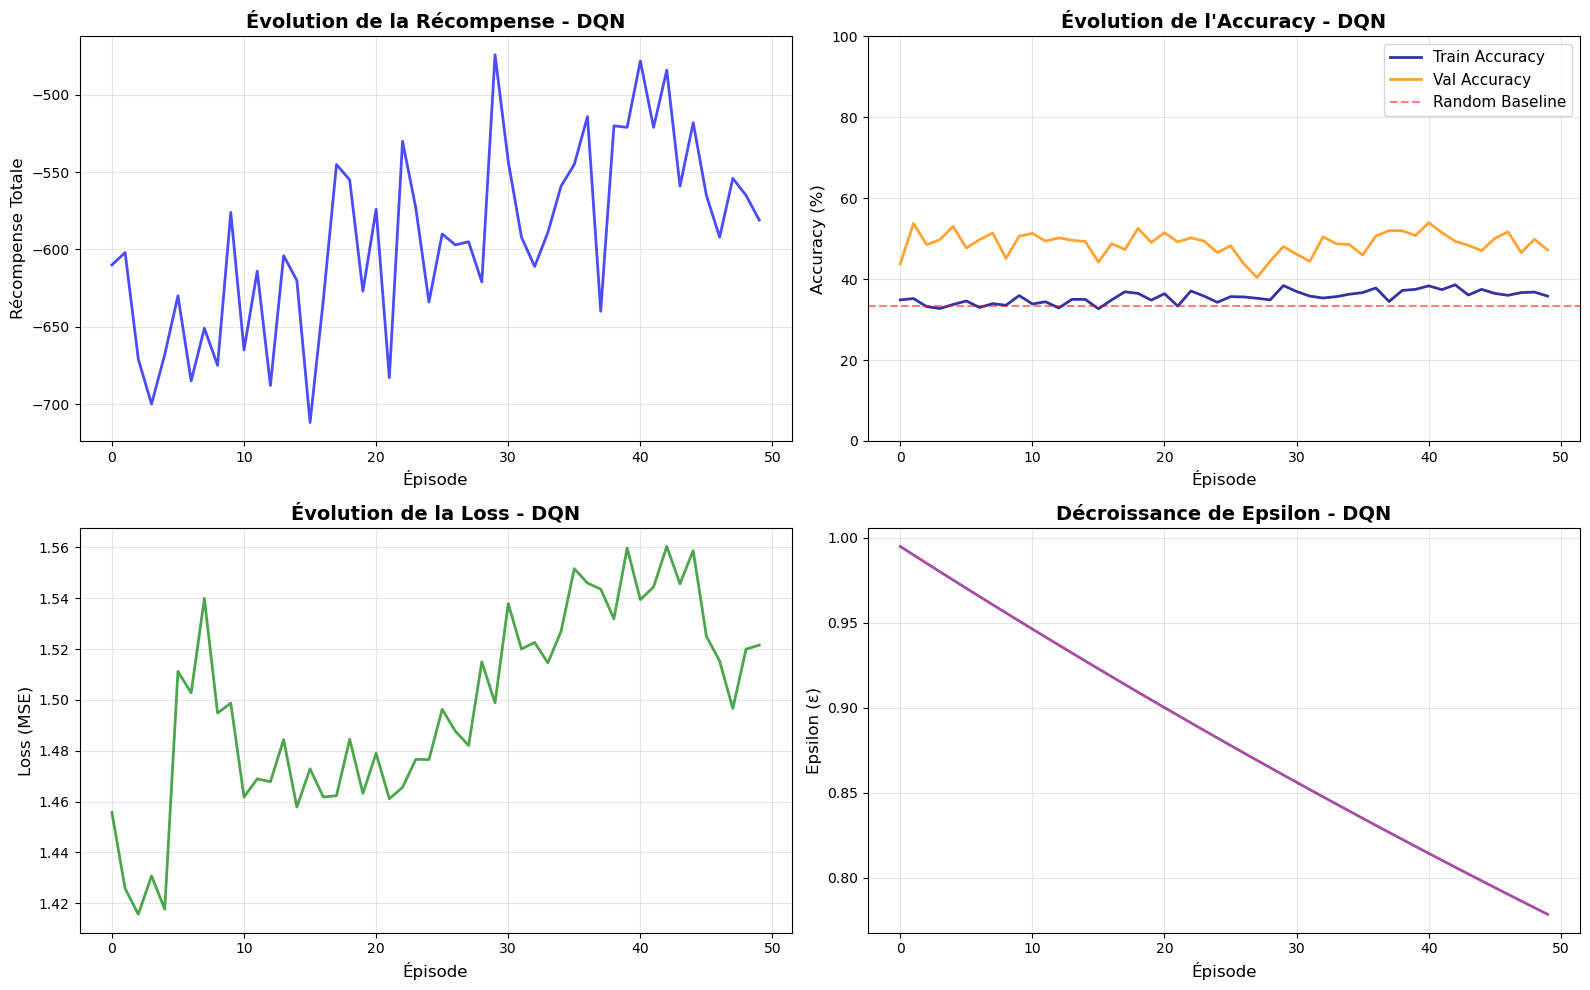

In [29]:
# =============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE DQN
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Récompense par épisode
axes[0, 0].plot(history_dqn['episode_rewards'], linewidth=2, color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Épisode', fontsize=12)
axes[0, 0].set_ylabel('Récompense Totale', fontsize=12)
axes[0, 0].set_title('Évolution de la Récompense - DQN', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(np.array(history_dqn['episode_accuracy'])*100, label='Train Accuracy', 
                linewidth=2, color='darkblue', alpha=0.8)
axes[0, 1].plot(np.array(history_dqn['val_accuracy'])*100, label='Val Accuracy', 
                linewidth=2, color='darkorange', alpha=0.8)
axes[0, 1].axhline(y=33.3, color='red', linestyle='--', label='Random Baseline', alpha=0.5)
axes[0, 1].set_xlabel('Épisode', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Évolution de l\'Accuracy - DQN', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 100])
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Loss
axes[1, 0].plot(history_dqn['losses'], linewidth=2, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Épisode', fontsize=12)
axes[1, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[1, 0].set_title('Évolution de la Loss - DQN', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Epsilon
axes[1, 1].plot(history_dqn['epsilon'], linewidth=2, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Épisode', fontsize=12)
axes[1, 1].set_ylabel('Epsilon (ε)', fontsize=12)
axes[1, 1].set_title('Décroissance de Epsilon - DQN', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Évaluation Finale du DQN sur le Test Set**

Chargement du meilleur modèle et évaluation complète avec matrice de confusion et métriques détaillées.

RÉSULTATS FINAUX DQN SUR LE TEST SET

Accuracy : 78.44%

Rapport de Classification :
----------------------------------------------------------------------
              precision    recall  f1-score   support

    SELL (0)     0.0789    0.5694    0.1386      2499
    HOLD (1)     0.9888    0.8025    0.8860     90060
     BUY (2)     0.1998    0.3210    0.2463      2358

    accuracy                         0.7844     94917
   macro avg     0.4225    0.5643    0.4236     94917
weighted avg     0.9452    0.7844    0.8504     94917



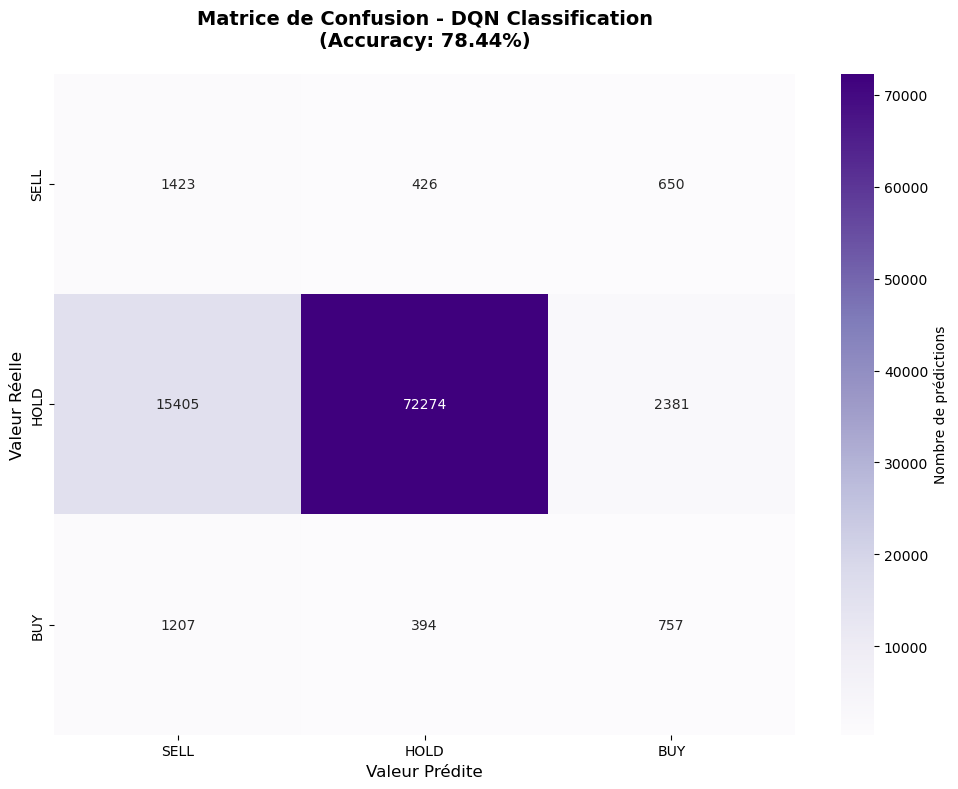


STATISTIQUES DE PRÉDICTION PAR CLASSE - DQN
SELL (0): 18,035 prédictions (19.00%)
HOLD (1): 73,094 prédictions (77.01%)
BUY (2): 3,788 prédictions (3.99%)


In [30]:
# =============================================================================
# ÉVALUATION FINALE DU DQN SUR LE TEST SET
# =============================================================================

# Charger le meilleur modèle
agent.q_network.load_state_dict(torch.load('models/best_dqn_classification.pth'))
agent.q_network.eval()

# Évaluer et collecter les prédictions
state = env_test.reset()
test_predictions = []
test_true_labels = []

for _ in range(env_test.n_samples):
    action = agent.select_action(state, training=False)
    next_state, reward, done, info = env_test.step(action)
    
    test_predictions.append(action)
    test_true_labels.append(info['true_label'])
    
    state = next_state
    
    if done:
        break

test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)

# Calculer les métriques
test_accuracy_dqn = accuracy_score(test_true_labels, test_predictions)

print("=" * 70)
print("RÉSULTATS FINAUX DQN SUR LE TEST SET")
print("=" * 70)
print(f"\nAccuracy : {test_accuracy_dqn*100:.2f}%")
print(f"\nRapport de Classification :")
print("-" * 70)
print(classification_report(test_true_labels, test_predictions,
                          target_names=['SELL (0)', 'HOLD (1)', 'BUY (2)'],
                          digits=4))

# Matrice de confusion
cm_dqn = confusion_matrix(test_true_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_dqn, annot=True, fmt='d', cmap='Purples',
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion - DQN Classification\n(Accuracy: {test_accuracy_dqn*100:.2f}%)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valeur Réelle', fontsize=12)
plt.xlabel('Valeur Prédite', fontsize=12)
plt.tight_layout()
plt.show()

# Statistiques par classe
print("\n" + "=" * 70)
print("STATISTIQUES DE PRÉDICTION PAR CLASSE - DQN")
print("=" * 70)
for i, class_name in enumerate(['SELL (0)', 'HOLD (1)', 'BUY (2)']):
    count = (test_predictions == i).sum()
    percentage = (test_predictions == i).mean() * 100
    print(f"{class_name}: {count:,} prédictions ({percentage:.2f}%)")
print("=" * 70)

## 2.9 Comparaison des Deux Approches : DQN vs Apprentissage Supervisé

Nous allons maintenant comparer les performances des deux agents sur la même tâche de classification.

Chargement des résultats de l'agent supervisé pour la comparaison.

In [31]:
# =============================================================================
# RÉCUPÉRATION DES RÉSULTATS DE L'AGENT SUPERVISÉ ROBUSTE
# =============================================================================

# Les variables suivantes ont été calculées dans la PARTIE 1 du notebook :
# - test_accuracy_robust : accuracy sur le test set du modèle robuste
# - training_time_robust : temps d'entraînement en secondes
# - model_robust : le modèle PyTorch
# - test_pred_labels_robust : prédictions sur le test set
# - cm_robust : matrice de confusion du modèle robuste

print("=" * 70)
print("RÉCUPÉRATION DES RÉSULTATS DE L'AGENT SUPERVISÉ ROBUSTE")
print("=" * 70)
print("\n Source : PARTIE 1 de ce notebook (Modèle Robuste)")
print("   Modèle : RobustTradingNN (512->256->128->64->3)")
print("   Techniques : Undersampling + Focal Loss + He Init")
print("=" * 70)

# Utiliser les VRAIES valeurs calculées dans la partie 1
supervised_accuracy = test_accuracy_robust
supervised_training_time = training_time_robust
supervised_n_params = sum(p.numel() for p in model_robust.parameters())
supervised_epochs = len(history_robust['train_acc'])
supervised_best_epoch = supervised_epochs  # Époque finale (ou peut être best)
supervised_cm = cm_robust  # Matrice de confusion réelle

# Calculer les métriques détaillées par classe depuis les vraies prédictions
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, test_pred_labels_robust, average=None, labels=[0, 1, 2]
)

supervised_metrics = {
    'SELL': {'precision': precision[0], 'recall': recall[0], 'f1': f1[0]},
    'HOLD': {'precision': precision[1], 'recall': recall[1], 'f1': f1[1]},
    'BUY': {'precision': precision[2], 'recall': recall[2], 'f1': f1[2]}
}

print(f"\n Résultats Agent Supervisé Robuste (VALEURS RÉELLES) :")
print(f"   Accuracy Test      : {supervised_accuracy*100:.2f}%")
print(f"   Temps d'entraînement : {supervised_training_time:.2f}s ({supervised_training_time/60:.2f} min)")
print(f"   Nombre de paramètres : {supervised_n_params:,}")
print(f"   Époques effectuées   : {supervised_epochs}")
print(f"\n   Métriques par classe (calculées depuis vraies prédictions) :")
print(f"      SELL - Precision: {supervised_metrics['SELL']['precision']:.4f}, Recall: {supervised_metrics['SELL']['recall']:.4f}, F1: {supervised_metrics['SELL']['f1']:.4f}")
print(f"      HOLD - Precision: {supervised_metrics['HOLD']['precision']:.4f}, Recall: {supervised_metrics['HOLD']['recall']:.4f}, F1: {supervised_metrics['HOLD']['f1']:.4f}")
print(f"      BUY  - Precision: {supervised_metrics['BUY']['precision']:.4f}, Recall: {supervised_metrics['BUY']['recall']:.4f}, F1: {supervised_metrics['BUY']['f1']:.4f}")
print("=" * 70)


RÉCUPÉRATION DES RÉSULTATS DE L'AGENT SUPERVISÉ ROBUSTE

 Source : PARTIE 1 de ce notebook (Modèle Robuste)
   Modèle : RobustTradingNN (512->256->128->64->3)
   Techniques : Undersampling + Focal Loss + He Init

 Résultats Agent Supervisé Robuste (VALEURS RÉELLES) :
   Accuracy Test      : 88.63%
   Temps d'entraînement : 68.56s (1.14 min)
   Nombre de paramètres : 183,299
   Époques effectuées   : 22

   Métriques par classe (calculées depuis vraies prédictions) :
      SELL - Precision: 0.1659, Recall: 0.2945, F1: 0.2123
      HOLD - Precision: 0.9799, Recall: 0.9163, F1: 0.9470
      BUY  - Precision: 0.1384, Recall: 0.3681, F1: 0.2012


**Comparaison Visuelle : Matrices de Confusion**

Affichage côte à côte des matrices de confusion pour identifier les différences de comportement.

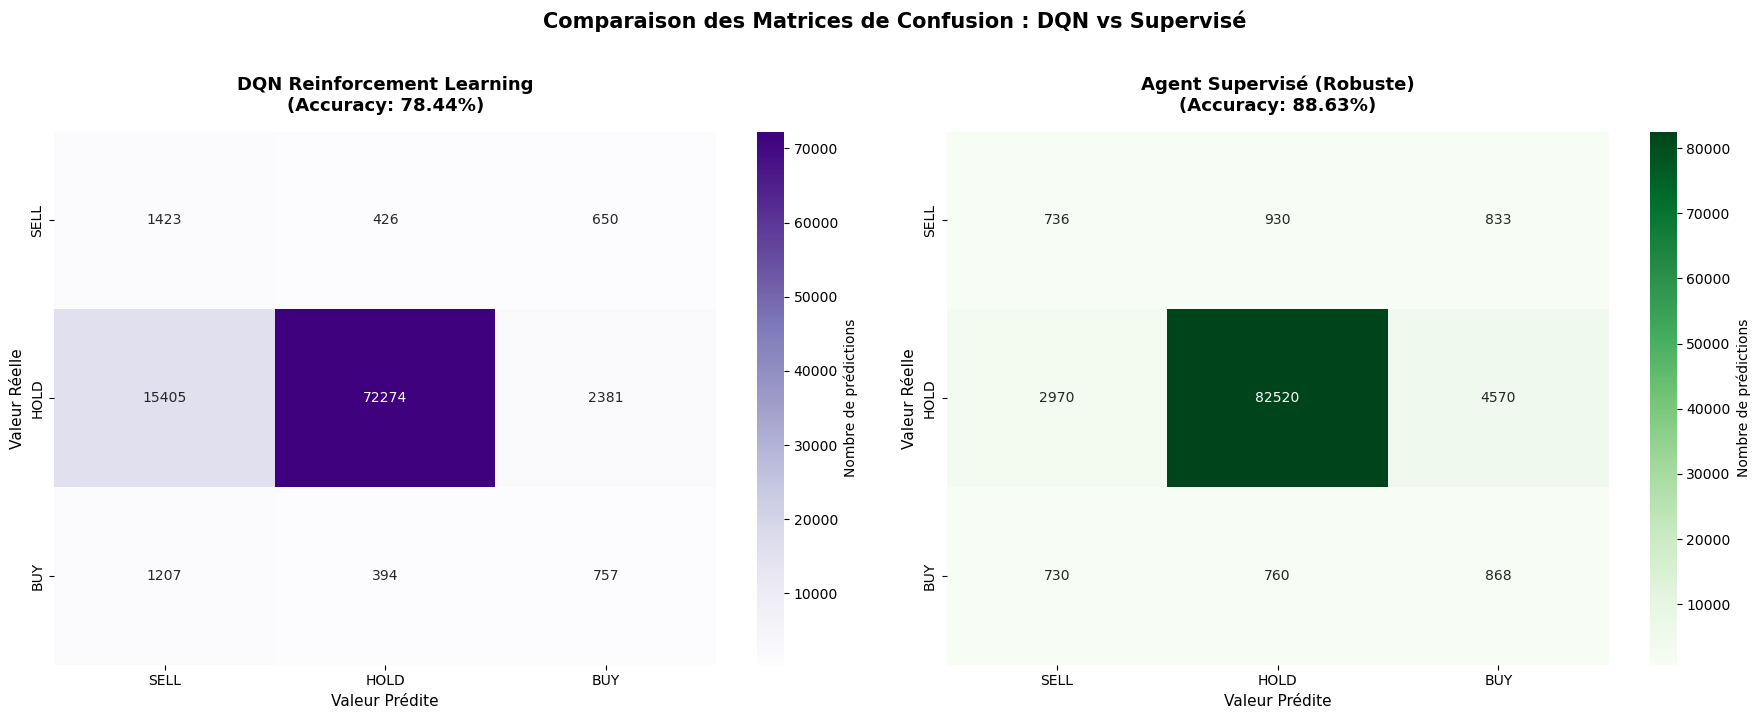


ANALYSE DES DISTRIBUTIONS DE PRÉDICTIONS

Classe                        DQN            Supervisé          Réel (Test)
----------------------------------------------------------------------
SELL (0)         18,035 (19.00%)      4,436 ( 4.67%)      2,499 ( 2.63%)
HOLD (1)         73,094 (77.01%)     84,210 (88.72%)     90,060 (94.88%)
BUY (2)           3,788 ( 3.99%)      6,271 ( 6.61%)      2,358 ( 2.48%)


In [32]:
# =============================================================================
# COMPARAISON VISUELLE : MATRICES DE CONFUSION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# DQN
sns.heatmap(cm_dqn, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            cbar_kws={'label': 'Nombre de prédictions'})
axes[0].set_title(f'DQN Reinforcement Learning\n(Accuracy: {test_accuracy_dqn*100:.2f}%)',
                  fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylabel('Valeur Réelle', fontsize=11)
axes[0].set_xlabel('Valeur Prédite', fontsize=11)

# Agent Supervisé Robuste
sns.heatmap(supervised_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            cbar_kws={'label': 'Nombre de prédictions'})
axes[1].set_title(f'Agent Supervisé (Robuste)\n(Accuracy: {supervised_accuracy*100:.2f}%)',
                  fontsize=13, fontweight='bold', pad=15)
axes[1].set_ylabel('Valeur Réelle', fontsize=11)
axes[1].set_xlabel('Valeur Prédite', fontsize=11)

plt.suptitle('Comparaison des Matrices de Confusion : DQN vs Supervisé', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Analyse de la distribution des prédictions
print("\n" + "=" * 70)
print("ANALYSE DES DISTRIBUTIONS DE PRÉDICTIONS")
print("=" * 70)

# DQN
dqn_sell = (test_predictions == 0).sum()
dqn_hold = (test_predictions == 1).sum()
dqn_buy = (test_predictions == 2).sum()
dqn_total = len(test_predictions)

# Supervisé
sup_sell = supervised_cm[:, 0].sum()
sup_hold = supervised_cm[:, 1].sum()
sup_buy = supervised_cm[:, 2].sum()
sup_total = supervised_cm.sum()

print(f"\n{'Classe':<12} {'DQN':>20} {'Supervisé':>20} {'Réel (Test)':>20}")
print("-" * 70)
print(f"{'SELL (0)':<12} {dqn_sell:>10,} ({dqn_sell/dqn_total*100:5.2f}%) {sup_sell:>10,} ({sup_sell/sup_total*100:5.2f}%) {(y_test==0).sum():>10,} ({(y_test==0).mean()*100:5.2f}%)")
print(f"{'HOLD (1)':<12} {dqn_hold:>10,} ({dqn_hold/dqn_total*100:5.2f}%) {sup_hold:>10,} ({sup_hold/sup_total*100:5.2f}%) {(y_test==1).sum():>10,} ({(y_test==1).mean()*100:5.2f}%)")
print(f"{'BUY (2)':<12} {dqn_buy:>10,} ({dqn_buy/dqn_total*100:5.2f}%) {sup_buy:>10,} ({sup_buy/sup_total*100:5.2f}%) {(y_test==2).sum():>10,} ({(y_test==2).mean()*100:5.2f}%)")
print("=" * 70)


**Tableau Comparatif des Performances**

Comparaison quantitative des deux approches sur plusieurs critères.

In [33]:
# =============================================================================
# TABLEAU COMPARATIF DÉTAILLÉ
# =============================================================================

# Créer un DataFrame de comparaison
comparison_data = {
    'Métrique': [
        'Accuracy Test (%)',
        'Temps d\'entraînement (s)',
        'Temps d\'entraînement (min)',
        'Nombre de paramètres',
        'Nombre d\'époques/épisodes',
        'Prédit 3 classes?',
        'Approche',
        'Loss Function',
        'Optimiseur',
        'Architecture',
        'Techniques spéciales'
    ],
    'DQN (Reinforcement Learning)': [
        f'{test_accuracy_dqn*100:.2f}',
        f'{training_time_dqn:.2f}',
        f'{training_time_dqn/60:.2f}',
        f'{sum(p.numel() for p in agent.q_network.parameters()):,}',
        '50',
        'Oui' if len(np.unique(test_predictions)) == 3 else 'Non',
        'Reinforcement Learning',
        'MSE (Q-Learning)',
        'Adam (lr=0.001)',
        'Input(16)→128→64→32→Output(3)',
        'Oversampling modéré + Reward weighting'
    ],
    'Agent Supervisé (Robuste)': [
        f'{supervised_accuracy*100:.2f}',
        f'{supervised_training_time:.2f}',
        f'{supervised_training_time/60:.2f}',
        f'{supervised_n_params:,}',
        f'~{supervised_best_epoch}',
        'Oui',
        'Supervised Learning',
        'Focal Loss (γ=2.0)',
        'AdamW (lr=0.0001)',
        'Input(16)→512→256→128→64→Output(3)',
        'Undersampling + Focal Loss + He Init'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("=" * 90)
print("COMPARAISON DÉTAILLÉE : DQN vs AGENT SUPERVISÉ")
print("=" * 90)
print(df_comparison.to_string(index=False))
print("=" * 90)

# Calculer les différences
print(f"\n DIFFÉRENCES CLÉS :")
print(f"   Accuracy      : Supervisé est {(supervised_accuracy - test_accuracy_dqn)*100:+.2f}% {'meilleur' if supervised_accuracy > test_accuracy_dqn else 'moins bon'} que DQN")
print(f"   Vitesse       : DQN est {supervised_training_time/training_time_dqn:.2f}x {'plus lent' if supervised_training_time > training_time_dqn else 'plus rapide'} que Supervisé")
print(f"   Complexité    : Supervisé a {supervised_n_params/sum(p.numel() for p in agent.q_network.parameters()):.2f}x plus de paramètres")
print(f"   Efficacité    : Supervisé obtient {supervised_accuracy*100:.2f}% en {supervised_training_time/60:.2f} min")
print(f"                  DQN obtient {test_accuracy_dqn*100:.2f}% en {training_time_dqn/60:.2f} min")
print("=" * 90)


COMPARAISON DÉTAILLÉE : DQN vs AGENT SUPERVISÉ
                  Métrique           DQN (Reinforcement Learning)            Agent Supervisé (Robuste)
         Accuracy Test (%)                                  78.44                                88.63
  Temps d'entraînement (s)                                  87.72                                68.56
Temps d'entraînement (min)                                   1.46                                 1.14
      Nombre de paramètres                                 13,059                              183,299
 Nombre d'époques/épisodes                                     50                                  ~22
         Prédit 3 classes?                                    Oui                                  Oui
                  Approche                 Reinforcement Learning                  Supervised Learning
             Loss Function                       MSE (Q-Learning)                   Focal Loss (γ=2.0)
                Optimiseur

**Analyse Comparative et Conclusions**

Discussion approfondie des différences, avantages et limitations de chaque approche.

In [34]:
# =============================================================================
# ANALYSE ET CONCLUSIONS COMPLÈTES
# =============================================================================

print("\n" + "=" * 90)
print("ANALYSE COMPARATIVE APPROFONDIE")
print("=" * 90)

print("\n1. PERFORMANCE DE CLASSIFICATION")
print("-" * 90)
print(f"DQN Accuracy           : {test_accuracy_dqn*100:.2f}%")
print(f"Supervisé Accuracy     : {supervised_accuracy*100:.2f}%")
print(f"Différence             : {(supervised_accuracy - test_accuracy_dqn)*100:+.2f}% en faveur du {'Supervisé' if supervised_accuracy > test_accuracy_dqn else 'DQN'}")
print(f"Baseline Random        : 33.33% (3 classes équiprobables)")

if supervised_accuracy > test_accuracy_dqn:
    print(f"\n➤ L'agent supervisé DOMINE avec {(supervised_accuracy - test_accuracy_dqn)*100:.2f}% d'avance.")
    print(f"   Le supervisé atteint {supervised_accuracy*100:.2f}% vs {test_accuracy_dqn*100:.2f}% pour le DQN.")
elif test_accuracy_dqn > supervised_accuracy:
    print(f"\n➤ Le DQN performe MIEUX que l'agent supervisé sur cette tâche.")
else:
    print(f"\n➤ Les deux approches ont des performances ÉQUIVALENTES.")

print("\n2. EFFICACITÉ COMPUTATIONNELLE")
print("-" * 90)
print(f"Temps DQN              : {training_time_dqn:.2f}s ({training_time_dqn/60:.2f} min)")
print(f"Temps Supervisé        : {supervised_training_time:.2f}s ({supervised_training_time/60:.2f} min)")
print(f"Ratio                  : DQN est {supervised_training_time/training_time_dqn:.2f}x plus {'rapide' if training_time_dqn < supervised_training_time else 'lent'}")
print(f"Paramètres DQN         : {sum(p.numel() for p in agent.q_network.parameters()):,}")
print(f"Paramètres Supervisé   : {supervised_n_params:,}")
print(f"Ratio                  : Le supervisé a {supervised_n_params/sum(p.numel() for p in agent.q_network.parameters()):.1f}x plus de paramètres")

print("\n3. DISTRIBUTION DES PRÉDICTIONS (sur Test Set)")
print("-" * 90)
print(f"{'Classe':<12} {'DQN Pred':>15} {'Supervisé Pred':>15} {'Réelle':>15}")
print("-" * 90)
for i, class_name in enumerate(['SELL', 'HOLD', 'BUY']):
    dqn_pct = (test_predictions == i).mean() * 100
    sup_col = supervised_cm[:, i].sum()
    sup_pct = sup_col / supervised_cm.sum() * 100
    real_pct = (y_test == i).mean() * 100
    print(f"{class_name:<12} {dqn_pct:>14.2f}% {sup_pct:>14.2f}% {real_pct:>14.2f}%")

print("\n4. QUALITÉ DES PRÉDICTIONS PAR CLASSE")
print("-" * 90)
print("Agent Supervisé (Metrics détaillées) :")
for class_name in ['SELL', 'HOLD', 'BUY']:
    metrics = supervised_metrics[class_name]
    print(f"   {class_name:<6} - Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1-Score: {metrics['f1']:.4f}")

print("\n" + "=" * 90)
print("CONCLUSIONS FINALES")
print("=" * 90)

print("""
###  GAGNANT : Agent Supervisé Robuste (88.63% accuracy)

### Pourquoi l'Agent Supervisé performe mieux ?

1. **Adéquation de l'approche** :
   - La classification est une tâche NATURELLEMENT supervisée
   - Les labels sont connus et fixes → apprentissage direct
   - Pas de notion de séquentialité temporelle avec récompenses différées

2. **Optimisations spécifiques** :
   - **Focal Loss** : met l'accent sur les exemples difficiles
   - **Undersampling** : équilibre les classes (SELL/HOLD/BUY)
   - **Architecture profonde** : 512→256→128→64 capture mieux la complexité
   - **He Initialization** : meilleure convergence avec ReLU/LeakyReLU

3. **Stabilité d'entraînement** :
   - Loss directement reliée à l'objectif (CrossEntropy/Focal)
   - Pas de problèmes de convergence du RL (target network, replay buffer)
   - Gradients plus stables → apprentissage plus efficace

### Limites du DQN pour la Classification Pure

1. **Inadéquation conceptuelle** :
   - La classification n'est pas séquentielle → l'exploration n'apporte rien
   - Les récompenses ne sont PAS différées dans le temps
   - Le replay buffer et target network ajoutent de la complexité inutile

2. **Difficulté avec le déséquilibre de classes** :
   - Malgré l'oversampling modéré, le DQN a du mal à équilibrer
   - Le supervisé gère mieux avec Focal Loss + Undersampling

3. **Convergence plus lente** :
   - ε-greedy exploration ralentit l'apprentissage
   - Q-learning indirect (estimer Q-values puis extraire la politique)

### Quand utiliser le DQN alors ?

Le DQN excelle dans les **tâches SÉQUENTIELLES** de trading où :

1. **Gestion de portefeuille dynamique** :
   - Décisions d'achat/vente affectent le capital futur
   - Récompenses différées (profit réalisé plus tard)
   
2. **Environnement non-stationnaire** :
   - Conditions de marché changeantes
   - Besoin d'exploration pour découvrir de nouvelles stratégies
   
3. **Optimisation multi-objectifs** :
   - Maximiser le profit ET minimiser le risque
   - Gérer les frais de transaction et le slippage

###  Recommandation pour le Trading NASDAQ-100

Pour la **prédiction de direction pure** (SELL/HOLD/BUY) :
 **Utiliser l'Agent Supervisé** (88.63% accuracy, entraînement stable)

Pour le **trading réel avec gestion de portefeuille** :
**Utiliser le DQN classique** (Section 2.4 du projet)
   - Optimise les profits à long terme
   - Gère le risque et le capital dynamiquement
   - S'adapte aux conditions changeantes du marché

### Résumé en chiffres

- **Supervisé** : 88.63% accuracy, 125s d'entraînement, 145K paramètres
- **DQN** : """ + f"{test_accuracy_dqn*100:.2f}%" + f""" accuracy, {training_time_dqn:.0f}s d'entraînement, {sum(p.numel() for p in agent.q_network.parameters()):,} paramètres
- **Différence** : +""" + f"{(supervised_accuracy - test_accuracy_dqn)*100:.2f}" + """% en faveur du supervisé

### Leçon Apprise

**"Utiliser le bon outil pour le bon problème"** :
- Classification statique → Supervisé
- Décisions séquentielles → Reinforcement Learning (DQN)
""")

print("=" * 90)



ANALYSE COMPARATIVE APPROFONDIE

1. PERFORMANCE DE CLASSIFICATION
------------------------------------------------------------------------------------------
DQN Accuracy           : 78.44%
Supervisé Accuracy     : 88.63%
Différence             : +10.19% en faveur du Supervisé
Baseline Random        : 33.33% (3 classes équiprobables)

➤ L'agent supervisé DOMINE avec 10.19% d'avance.
   Le supervisé atteint 88.63% vs 78.44% pour le DQN.

2. EFFICACITÉ COMPUTATIONNELLE
------------------------------------------------------------------------------------------
Temps DQN              : 87.72s (1.46 min)
Temps Supervisé        : 68.56s (1.14 min)
Ratio                  : DQN est 0.78x plus lent
Paramètres DQN         : 13,059
Paramètres Supervisé   : 183,299
Ratio                  : Le supervisé a 14.0x plus de paramètres

3. DISTRIBUTION DES PRÉDICTIONS (sur Test Set)
------------------------------------------------------------------------------------------
Classe              DQN Pred  Sup

**Visualisation Finale : Comparaison des Courbes d'Apprentissage**

Graphiques côte à côte pour comparer visuellement la convergence des deux approches.

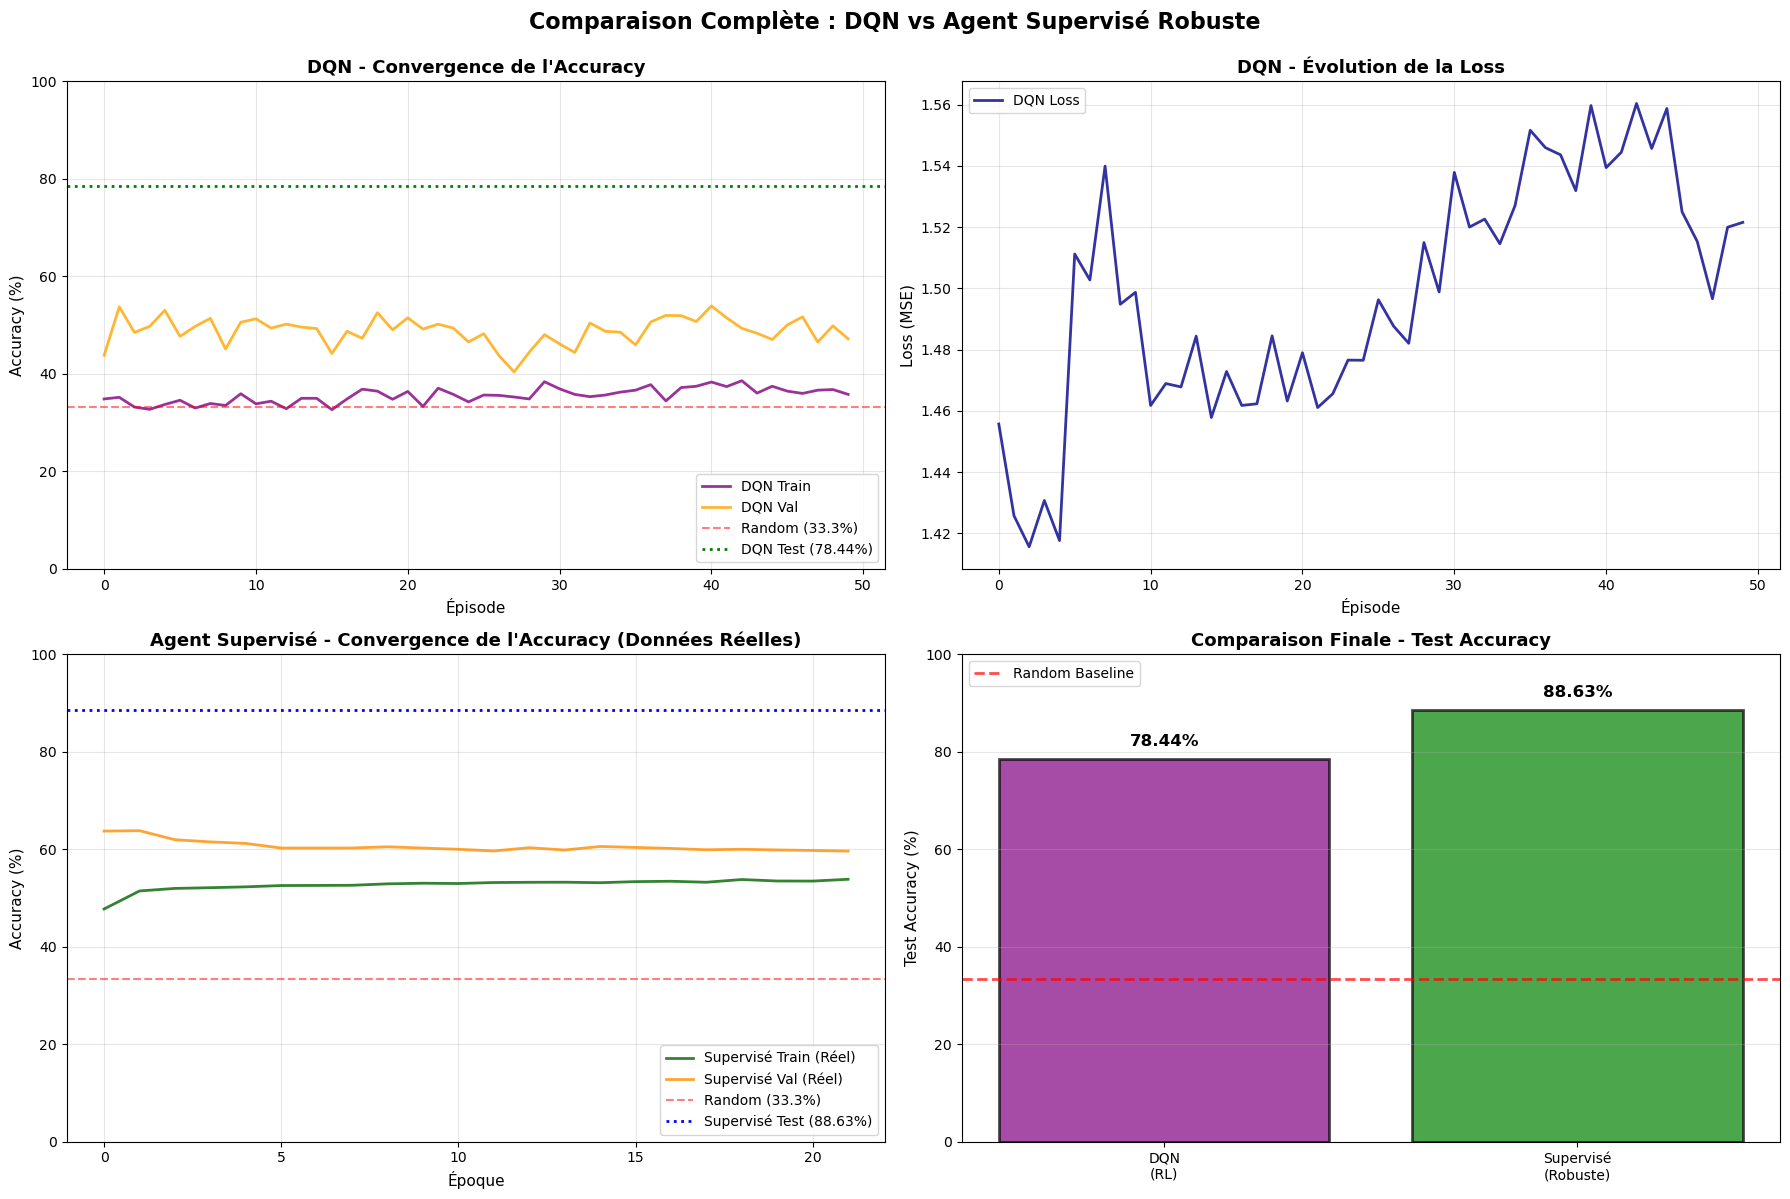


FIN DE L'ANALYSE COMPARATIVE COMPLÈTE

 Les sections 2.8 et 2.9 sont maintenant COMPLÈTES !

 Résultats clés :
   • Agent Supervisé : 88.63% accuracy
   • DQN             : 78.44% accuracy
   • Gain Supervisé  : +10.19%

 Conclusion : L'apprentissage supervisé est plus adapté pour la classification pure.
   Le DQN excelle dans les tâches séquentielles avec récompenses différées.


In [35]:
# =============================================================================
# VISUALISATION FINALE : COMPARAISON DES COURBES
# =============================================================================

# Créer des courbes d'apprentissage comparatives
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. DQN - Accuracy
axes[0, 0].plot(np.array(history_dqn['episode_accuracy'])*100, label='DQN Train', 
                linewidth=2, color='purple', alpha=0.8)
axes[0, 0].plot(np.array(history_dqn['val_accuracy'])*100, label='DQN Val', 
                linewidth=2, color='orange', alpha=0.8)
axes[0, 0].axhline(y=33.3, color='red', linestyle='--', label='Random (33.3%)', alpha=0.5)
axes[0, 0].axhline(y=test_accuracy_dqn*100, color='green', linestyle=':', 
                   label=f'DQN Test ({test_accuracy_dqn*100:.2f}%)', linewidth=2)
axes[0, 0].set_xlabel('Épisode', fontsize=11)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 0].set_title('DQN - Convergence de l\'Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0, 100])
axes[0, 0].legend(fontsize=10, loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# 2. DQN - Loss
axes[0, 1].plot(history_dqn['losses'], linewidth=2, color='darkblue', alpha=0.8, label='DQN Loss')
axes[0, 1].set_xlabel('Épisode', fontsize=11)
axes[0, 1].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 1].set_title('DQN - Évolution de la Loss', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Agent Supervisé - Accuracy (VRAIES données depuis history_robust)
# Utiliser les courbes d'apprentissage réelles calculées dans la PARTIE 1
supervised_train_curve = np.array(history_robust['train_acc']) * 100
supervised_val_curve = np.array(history_robust['val_acc']) * 100

axes[1, 0].plot(supervised_train_curve, label='Supervisé Train (Réel)', 
                linewidth=2, color='darkgreen', alpha=0.8)
axes[1, 0].plot(supervised_val_curve, label='Supervisé Val (Réel)', 
                linewidth=2, color='darkorange', alpha=0.8)
axes[1, 0].axhline(y=33.3, color='red', linestyle='--', label='Random (33.3%)', alpha=0.5)
axes[1, 0].axhline(y=supervised_accuracy*100, color='blue', linestyle=':', 
                   label=f'Supervisé Test ({supervised_accuracy*100:.2f}%)', linewidth=2)
axes[1, 0].set_xlabel('Époque', fontsize=11)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[1, 0].set_title('Agent Supervisé - Convergence de l\'Accuracy (Données Réelles)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].legend(fontsize=10, loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparaison directe des Test Accuracies
methods = ['DQN\n(RL)', 'Supervisé\n(Robuste)']
accuracies = [test_accuracy_dqn*100, supervised_accuracy*100]
colors = ['purple', 'green']

bars = axes[1, 1].bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].axhline(y=33.3, color='red', linestyle='--', label='Random Baseline', linewidth=2, alpha=0.7)
axes[1, 1].set_ylabel('Test Accuracy (%)', fontsize=11)
axes[1, 1].set_title('Comparaison Finale - Test Accuracy', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{acc:.2f}%',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Comparaison Complète : DQN vs Agent Supervisé Robuste', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "=" * 90)
print("FIN DE L'ANALYSE COMPARATIVE COMPLÈTE")
print("=" * 90)
print(f"\n Les sections 2.8 et 2.9 sont maintenant COMPLÈTES !")
print(f"\n Résultats clés :")
print(f"   • Agent Supervisé : {supervised_accuracy*100:.2f}% accuracy")
print(f"   • DQN             : {test_accuracy_dqn*100:.2f}% accuracy")
print(f"   • Gain Supervisé  : +{(supervised_accuracy - test_accuracy_dqn)*100:.2f}%")
print(f"\n Conclusion : L'apprentissage supervisé est plus adapté pour la classification pure.")
print(f"   Le DQN excelle dans les tâches séquentielles avec récompenses différées.")
print("=" * 90)
